# Analysis of Global Nucleosome Positioning in *Arabidopsis thaliana*
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: April 6, 2021 </br>
**Description**: Micrococcal nuclease digestion with deep sequencing (MNase-seq) is a molecular biology technique that measures nucleosome occupancy across the whole genome. After processing paired-end MNase-seq data using the workflow here: https://github.com/etc27/MNaseseq-workflow/blob/main/README.md, a table is generated that contains nucleosome profiles across different genomic regions. The following code loads metadata from the generation of nucleosome TSS metaprofiles (profiles showing average nucleosome occupancy relative to the Transcription Start Site of genes) and performs dimensionality reduction and clustering analysis in order to learn meaningful patterns in the data. In combination with RNA sequencing (RNA-seq) data, information about global gene expression is also included in the models below to provide more information about gene features for cluster assignment. This code analyzes individual biological replicates corresponding to the same genotype.

In [1]:
#Load required dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision.transforms as transforms
import torch

## Load and Clean Data
First, I load the data generated using deeptools and clean by removing empty columns, adding columns corresponding to gene names, and subsectioning data by sample. I also take a look at the metaprofiles by plotting the sum over all genes.

In [2]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"
filename = "mnase-fcnorm-sm40-TSS-proteincoding.tab"
path_to_file = os.path.join(base_path, filename)
data_matrix = pd.read_csv(path_to_file, skiprows=2, sep='\t')

In [3]:
data_matrix

MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm  \
0                                          0.000000   
1                                          0.000000   
2                                          0.002044   
3                                          0.016360   
4                                          0.035570   
...                                             ...   
27438                                      0.017170   
27439                                      0.000000   
27440                                      0.008178   
27441                                      0.029440   
27442                                      0.063380   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.1  \
0                                            0.013900   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.049070   
...                                               ...   
27438                                        0.029030   
27439                                        0.000000   
27440                                        0.018810   
27441                                        0.024940   
27442                                        0.044570   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.2  \
0                                            0.020850   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.051110   
...                                               ...   
27438                                        0.040890   
27439                                        0.000000   
27440                                        0.028620   
27441                                        0.040480   
27442                                        0.045800   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.3  \
0                                            0.061330   
1                                            0.000000   
2                                            0.008178   
3                                            0.012270   
4                                            0.076870   
...                                               ...   
27438                                        0.048250   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.048660   
27442                                        0.044160   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.4  \
0                                            0.073600   
1                                            0.000000   
2                                            0.006133   
3                                            0.000000   
4                                            0.075640   
...                                               ...   
27438                                        0.067060   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.077690   
27442                                        0.050290   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.5  \
0                                            0.065830   
1                                            0.000000   
2                                            0.000000   
3                                            0.006951   
4                                            0.071960   
...                                               ...   
27438                                        0.060920   
27439                                        0.008587   
27440                                        0.013900   
27441                               

In [4]:
#Matrix containing gene names corresponding to each row of data_matrix
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"
filename = "mnase-fcnorm-merged-TSS-proteincoding.bed"
path_to_file = os.path.join(base_path, filename)
sorted_genes = pd.read_csv(path_to_file, sep='\t')
#Make dataframe containing gene names and relabel gene naming convention to correspond with RNA-seq data
gene_names = sorted_genes['name'].copy()
gene_num = len(gene_names)
for i in range(gene_num):
    newname = gene_names[i]
    if newname[0:2] == 'AT':
        gene_names[i] = newname[0:-2]

In [5]:
#Make metadata matrix (has profile values and gene names)
metadata = data_matrix.copy()
metadata['gene name'] = gene_names

In [6]:
metadata

MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm  \
0                                          0.000000   
1                                          0.000000   
2                                          0.002044   
3                                          0.016360   
4                                          0.035570   
...                                             ...   
27438                                      0.017170   
27439                                      0.000000   
27440                                      0.008178   
27441                                      0.029440   
27442                                      0.063380   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.1  \
0                                            0.013900   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.049070   
...                                               ...   
27438                                        0.029030   
27439                                        0.000000   
27440                                        0.018810   
27441                                        0.024940   
27442                                        0.044570   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.2  \
0                                            0.020850   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.051110   
...                                               ...   
27438                                        0.040890   
27439                                        0.000000   
27440                                        0.028620   
27441                                        0.040480   
27442                                        0.045800   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.3  \
0                                            0.061330   
1                                            0.000000   
2                                            0.008178   
3                                            0.012270   
4                                            0.076870   
...                                               ...   
27438                                        0.048250   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.048660   
27442                                        0.044160   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.4  \
0                                            0.073600   
1                                            0.000000   
2                                            0.006133   
3                                            0.000000   
4                                            0.075640   
...                                               ...   
27438                                        0.067060   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.077690   
27442                                        0.050290   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.5  \
0                                            0.065830   
1                                            0.000000   
2                                            0.000000   
3                                            0.006951   
4                                            0.071960   
...                                               ...   
27438                                        0.060920   
27439                                        0.008587   
27440                                        0.013900   
27441                               

In [7]:
#Function to read in profile values for tpm output files
def read_tpm_tab(path):
    tab_file = pd.read_csv(path_to_file, skiprows=1, sep='\t')
    tab_file.drop(tab_file.columns[202:], axis = 1, inplace = True)
    return(tab_file)

In [8]:
#gene groups to plot separated by tpm values from RNA-seq
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"

#Col
filename = "mnase-fcnorm-Coltpmreps.tab"
path_to_file = os.path.join(base_path, filename)
Col_tpm_vals = read_tpm_tab(path_to_file)

#H4WT
filename = "mnase-fcnorm-H4WTtpmreps.tab"
path_to_file = os.path.join(base_path, filename)
H4WT_tpm_vals = read_tpm_tab(path_to_file)

#R17A
filename = "mnase-fcnorm-R17Atpmreps.tab"
path_to_file = os.path.join(base_path, filename)
R17A_tpm_vals = read_tpm_tab(path_to_file)

In [9]:
Col_tpm_vals

bins Unnamed: 1       1.0       2.0       3.0       4.0       5.0  \
0  Col-1a  very high  0.032075  0.032306  0.031954  0.031672  0.031406   
1  Col-1a       high  0.031638  0.031599  0.031581  0.031448  0.031354   
2  Col-1a     medium  0.031182  0.030898  0.030907  0.031218  0.030792   
3  Col-1a        low  0.030693  0.030271  0.030109  0.029776  0.029728   
4  Col-1a   very low  0.030564  0.030458  0.030839  0.030716  0.030767   
5  Col-1b  very high  0.031429  0.031499  0.031117  0.030839  0.030559   
6  Col-1b       high  0.030673  0.030634  0.030859  0.030844  0.030972   
7  Col-1b     medium  0.029960  0.029777  0.029650  0.029723  0.029459   
8  Col-1b        low  0.029795  0.029399  0.029156  0.029151  0.029217   
9  Col-1b   very low  0.029387  0.029523  0.029967  0.030238  0.030077   

        6.0       7.0       8.0  ...     191.0     192.0     193.0     194.0  \
0  0.031119  0.031212  0.031456  ...  0.035005  0.035609  0.036070  0.036225   
1  0.031291  0.031332  0.031321  ...  0.036858  0.037302  0.037500  0.037763   
2  0.030685  0.030516  0.029960  ...  0.040176  0.040746  0.041522  0.041918   
3  0.029861  0.029971  0.030127  ...  0.043376  0.043165  0.043186  0.043352   
4  0.030655  0.030167  0.030132  ...  0.040368  0.039834  0.039244  0.038983   
5  0.030280  0.030415  0.030426  ...  0.033193  0.033445  0.033912  0.034276   
6  0.030788  0.030418  0.030403  ...  0.035677  0.035977  0.036032  0.035990   
7  0.029429  0.029297  0.028834  ...  0.040021  0.040857  0.041581  0.042074   
8  0.029544  0.029704  0.029935  ...  0.043496  0.043410  0.043849  0.044158   
9  0.030058  0.029807  0.029511  ...  0.039841  0.039446  0.038987  0.038874   

      195.0     196.0     197.0     198.0     199.0     200.0  
0  0.035998  0.035672  0.035131  0.034779  0.034576  0.034341  
1  0.037743  0.037697  0.037608  0.037359  0.037103  0.036631  
2  0.042437  0.042967  0.043060  0.042803  0.042298  0.041728  
3  0.043343  0.043110  0.042905  0.042792  0.042554  0.042436  
4  0.038731  0.038576  0.038444  0.038347  0.038282  0.037937  
5  0.034388  0.034163  0.033572  0.033062  0.032963  0.032932  
6  0.035679  0.035621  0.035566  0.035645  0.035457  0.034907  
7  0.042598  0.042541  0.042414  0.042216  0.041620  0.041233  
8  0.044483  0.044159  0.043583  0.043098  0.042743  0.042818  
9  0.038683  0.038686  0.038444  0.038034  0.038158  0.037665  

[10 rows x 202 columns]

## Plot by Gene Expression Level

In [10]:
plt.rcParams.update({'font.size': 16})
def plot_tpm_profiles(profile_vals, sample_num, names):
    for i in range(sample_num):
        #Subsection data
        num = i*5
        sample_low = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[4+num].tolist()
        sample_medlow = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[3+num].tolist()
        sample_med = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[2+num].tolist()
        sample_medhigh = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[1+num].tolist()
        sample_high = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[0+num].tolist()
        
        #Plot data
        x_vals = np.arange(-1000,1000,10)
        fig, axs = plt.subplots(1, 5, constrained_layout=True)
        fig.set_size_inches(22, 5)
        for ax in axs.flat:
            ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
        axs[0].plot(x_vals, sample_low, 'tab:blue')
        axs[0].set_title('Low Expression')
        axs[1].plot(x_vals,sample_medlow, 'tab:green')
        axs[1].set_title('Medium-Low Expression')
        axs[2].plot(x_vals,sample_med, 'tab:pink')
        axs[2].set_title('Medium Expression')
        axs[3].plot(x_vals,sample_medhigh, 'tab:orange')
        axs[3].set_title('Medium-High Expression')
        axs[4].plot(x_vals,sample_high, 'tab:red')
        axs[4].set_title('High Expression')
        fig.suptitle(names[i])
        plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tpm_profiles/"+names[i])

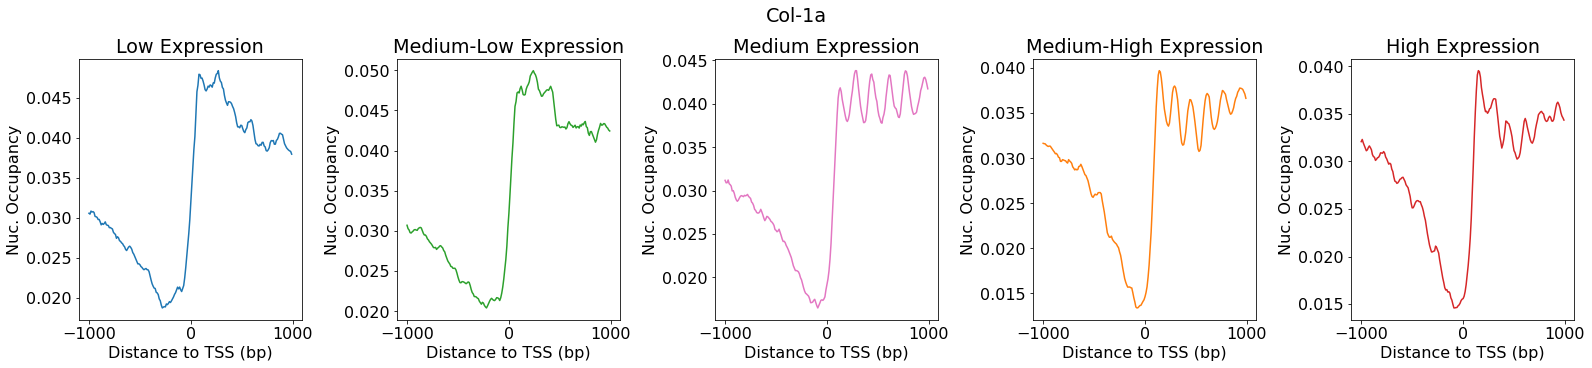

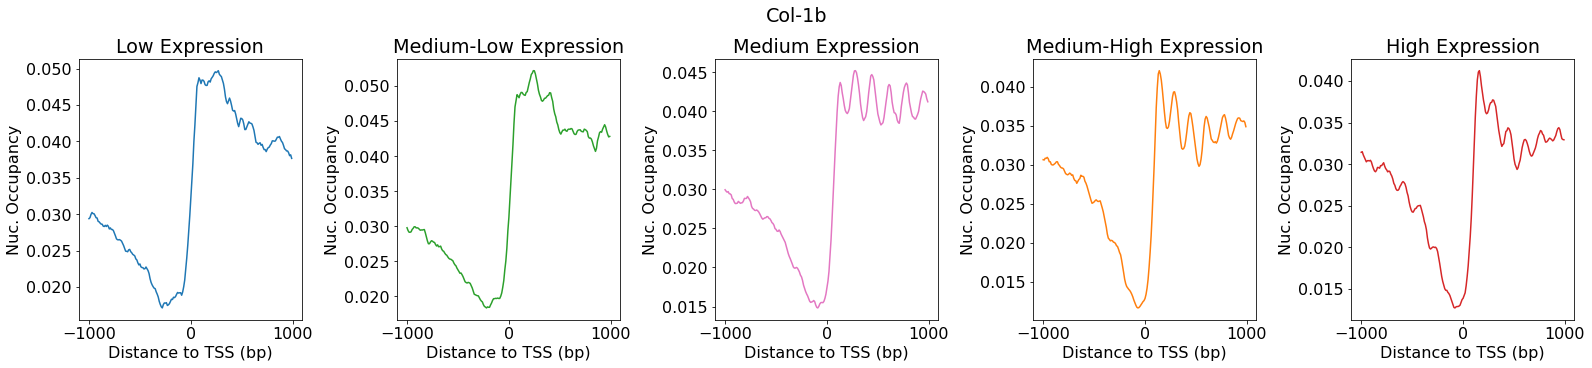

In [11]:
plot_tpm_profiles(Col_tpm_vals, 2, ["Col-1a", "Col-1b"])

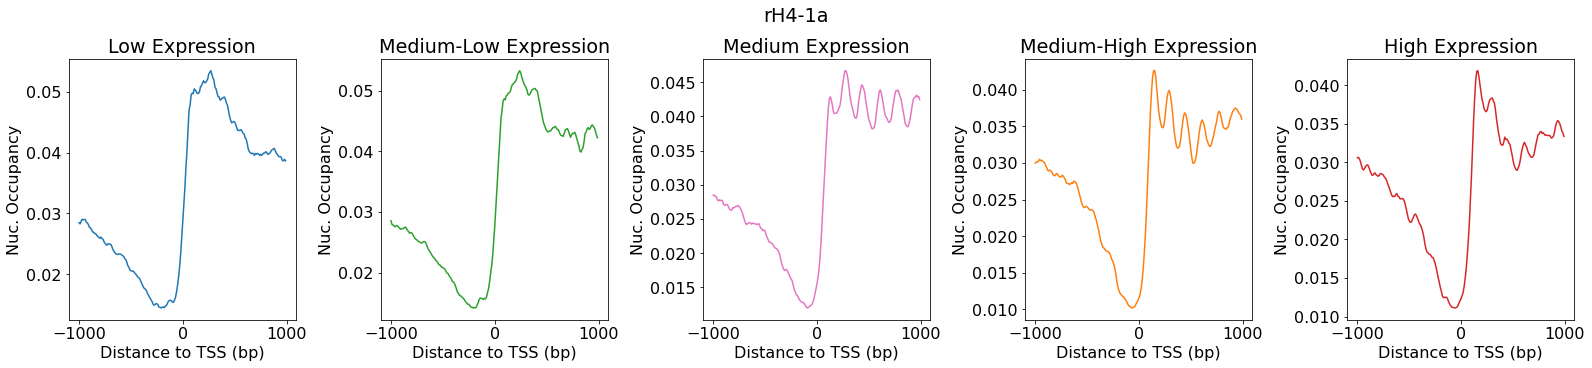

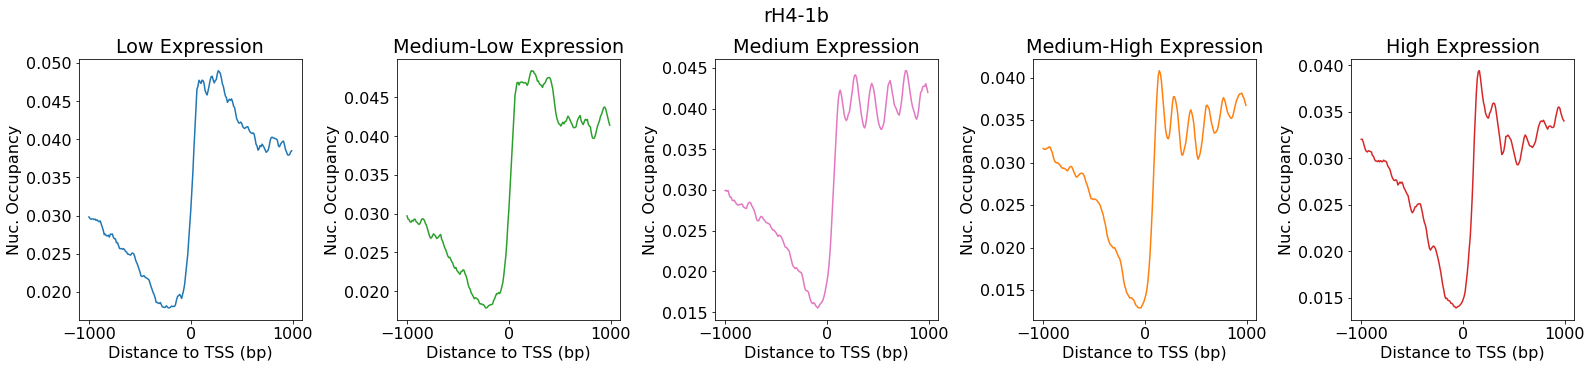

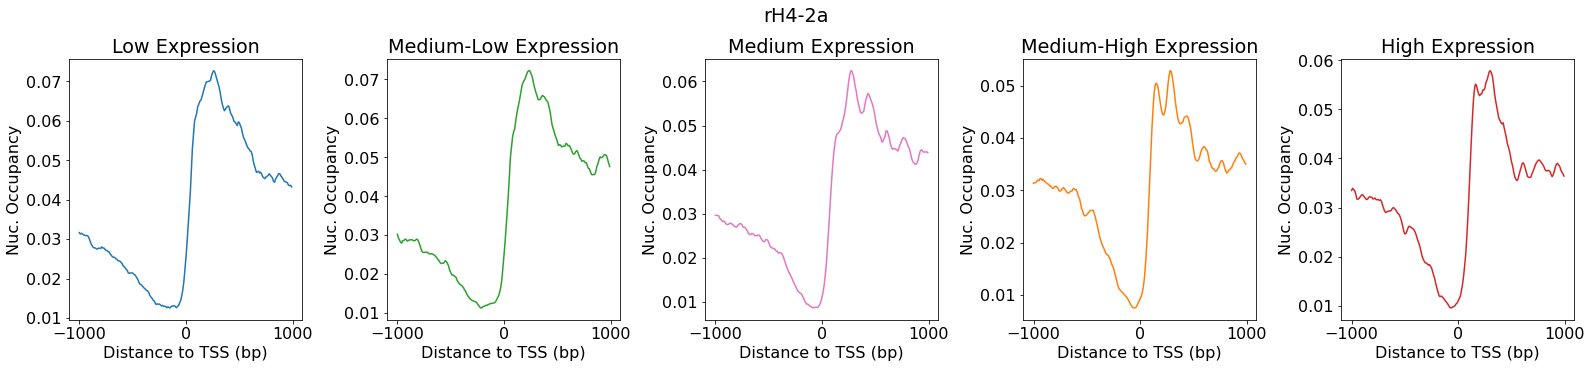

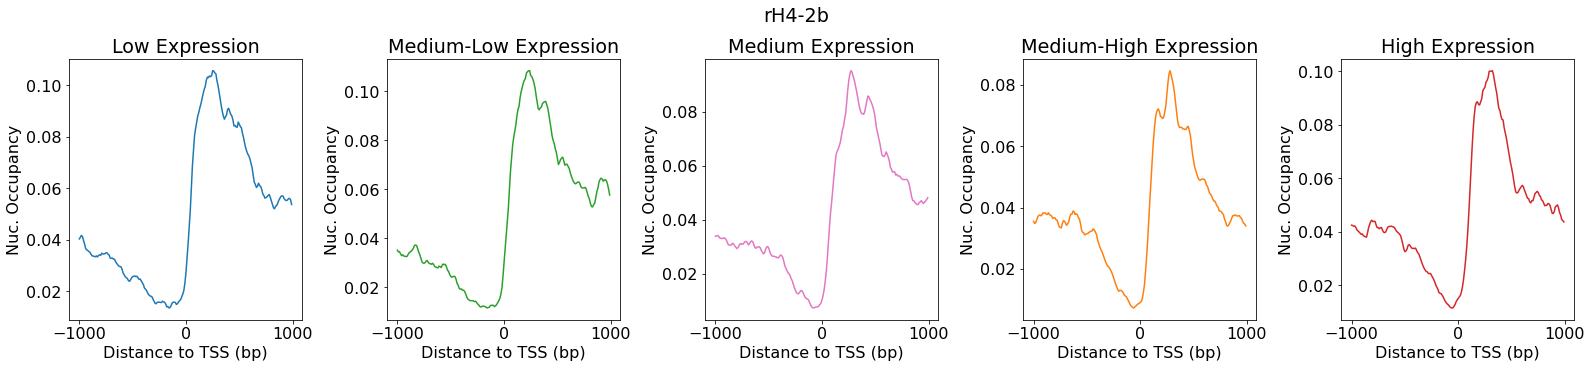

In [12]:
plot_tpm_profiles(H4WT_tpm_vals, 4, ["rH4-1a", "rH4-1b", "rH4-2a", "rH4-2b"])

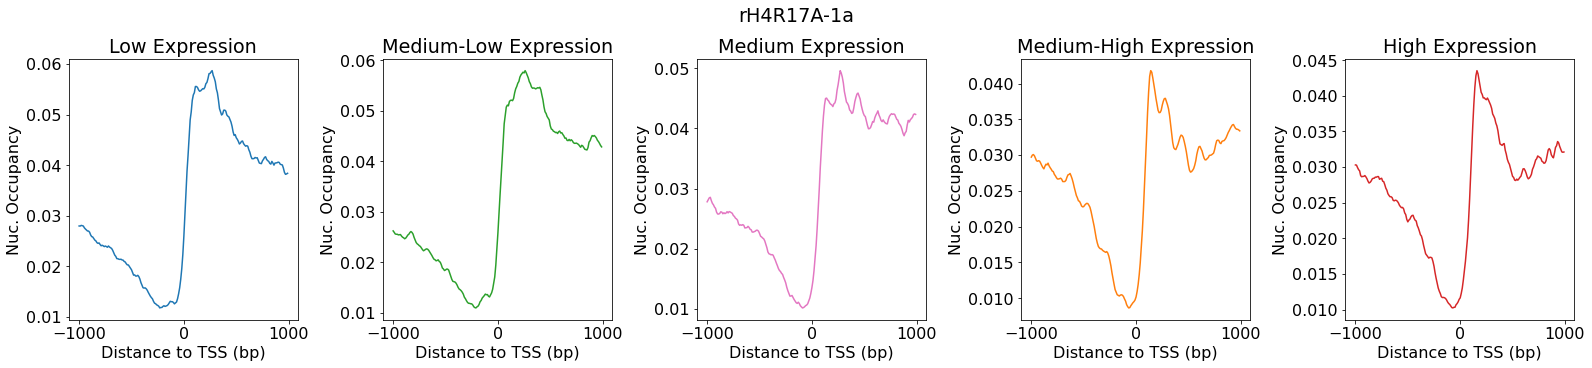

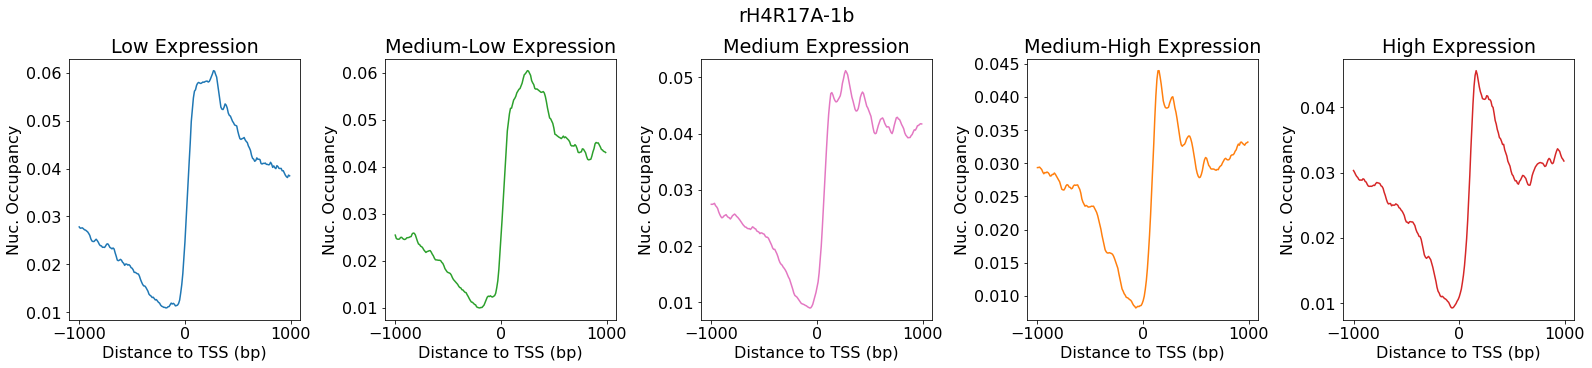

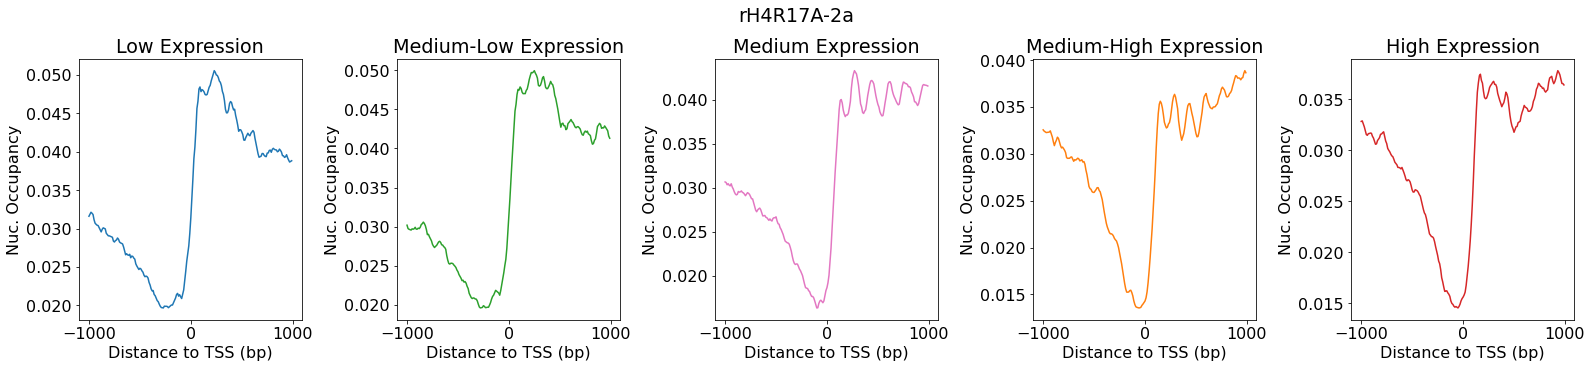

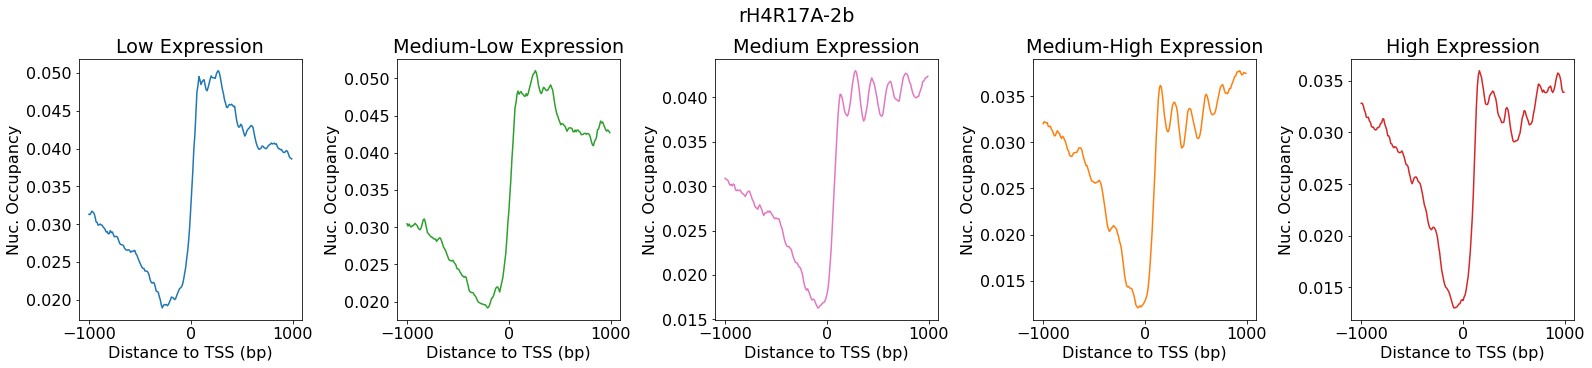

In [13]:
plot_tpm_profiles(R17A_tpm_vals, 4, ["rH4R17A-1a", "rH4R17A-1b", "rH4R17A-2a", "rH4R17A-2b"])

In [14]:
def tpm_profile(profile_vals, sample_num):
    #Subsection data
    num = sample_num*5
    sample_low = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[4+num].tolist()
    sample_medlow = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[3+num].tolist()
    sample_med = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[2+num].tolist()
    sample_medhigh = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[1+num].tolist()
    sample_high = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[0+num].tolist()
    return sample_low, sample_medlow, sample_med, sample_medhigh, sample_high

In [15]:
#Save tpm profile values as variable
#Col
Col_1a_low, Col_1a_medlow, Col_1a_med, Col_1a_medhigh, Col_1a_high = tpm_profile(Col_tpm_vals, 0)
Col_1b_low, Col_1b_medlow, Col_1b_med, Col_1b_medhigh, Col_1b_high = tpm_profile(Col_tpm_vals, 1)

#H4WT
H4WT_1a_low, H4WT_1a_medlow, H4WT_1a_med, H4WT_1a_medhigh, H4WT_1a_high = tpm_profile(H4WT_tpm_vals, 0)
H4WT_1b_low, H4WT_1b_medlow, H4WT_1b_med, H4WT_1b_medhigh, H4WT_1b_high = tpm_profile(H4WT_tpm_vals, 1)
H4WT_2a_low, H4WT_2a_medlow, H4WT_2a_med, H4WT_2a_medhigh, H4WT_2a_high = tpm_profile(H4WT_tpm_vals, 2)
H4WT_2b_low, H4WT_2b_medlow, H4WT_2b_med, H4WT_2b_medhigh, H4WT_2b_high = tpm_profile(H4WT_tpm_vals, 3)

#R17A
R17A_1a_low, R17A_1a_medlow, R17A_1a_med, R17A_1a_medhigh, R17A_1a_high = tpm_profile(R17A_tpm_vals, 0)
R17A_1b_low, R17A_1b_medlow, R17A_1b_med, R17A_1b_medhigh, R17A_1b_high = tpm_profile(R17A_tpm_vals, 1)
R17A_2a_low, R17A_2a_medlow, R17A_2a_med, R17A_2a_medhigh, R17A_2a_high = tpm_profile(R17A_tpm_vals, 2)
R17A_2b_low, R17A_2b_medlow, R17A_2b_med, R17A_2b_medhigh, R17A_2b_high = tpm_profile(R17A_tpm_vals, 3)

In [16]:
#Make pandas DataFrame to plot samples on sample axis
med_df = pd.DataFrame(Col_1a_med, columns=['Col_1a_med'])
med_df['Col_1b_med'] = Col_1b_med
med_df['H4WT_1a_med'] = H4WT_1a_med
med_df['H4WT_1b_med'] = H4WT_1b_med
med_df['H4WT_2a_med'] = H4WT_2a_med
med_df['H4WT_2b_med'] = H4WT_2b_med
med_df['R17A_1a_med'] = R17A_1a_med
med_df['R17A_1b_med'] = R17A_1b_med
med_df['R17A_2a_med'] = R17A_2a_med
med_df['R17A_2b_med'] = R17A_2b_med

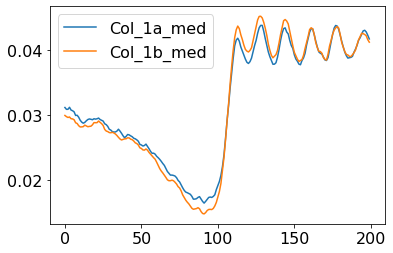

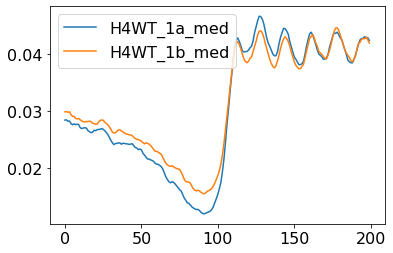

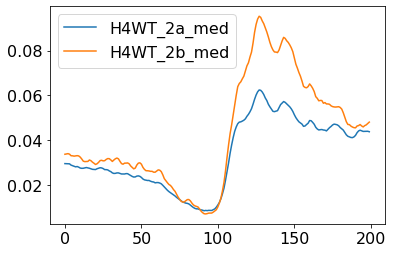

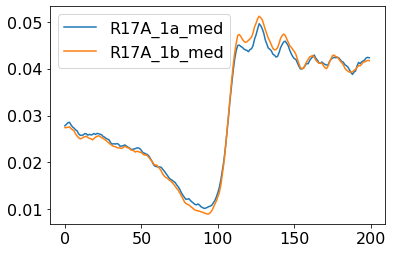

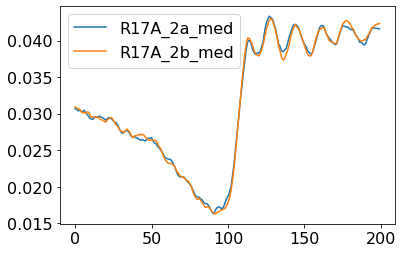

In [17]:
med_df.iloc[:,0:2].plot()
med_df.iloc[:,2:4].plot()
med_df.iloc[:,4:6].plot()
med_df.iloc[:,6:8].plot()
med_df.iloc[:,8:10].plot()
#med_df.plot()
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Plot sum of all genes

In [18]:
data_matrix

MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm  \
0                                          0.000000   
1                                          0.000000   
2                                          0.002044   
3                                          0.016360   
4                                          0.035570   
...                                             ...   
27438                                      0.017170   
27439                                      0.000000   
27440                                      0.008178   
27441                                      0.029440   
27442                                      0.063380   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.1  \
0                                            0.013900   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.049070   
...                                               ...   
27438                                        0.029030   
27439                                        0.000000   
27440                                        0.018810   
27441                                        0.024940   
27442                                        0.044570   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.2  \
0                                            0.020850   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.051110   
...                                               ...   
27438                                        0.040890   
27439                                        0.000000   
27440                                        0.028620   
27441                                        0.040480   
27442                                        0.045800   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.3  \
0                                            0.061330   
1                                            0.000000   
2                                            0.008178   
3                                            0.012270   
4                                            0.076870   
...                                               ...   
27438                                        0.048250   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.048660   
27442                                        0.044160   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.4  \
0                                            0.073600   
1                                            0.000000   
2                                            0.006133   
3                                            0.000000   
4                                            0.075640   
...                                               ...   
27438                                        0.067060   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.077690   
27442                                        0.050290   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.5  \
0                                            0.065830   
1                                            0.000000   
2                                            0.000000   
3                                            0.006951   
4                                            0.071960   
...                                               ...   
27438                                        0.060920   
27439                                        0.008587   
27440                                        0.013900   
27441                               

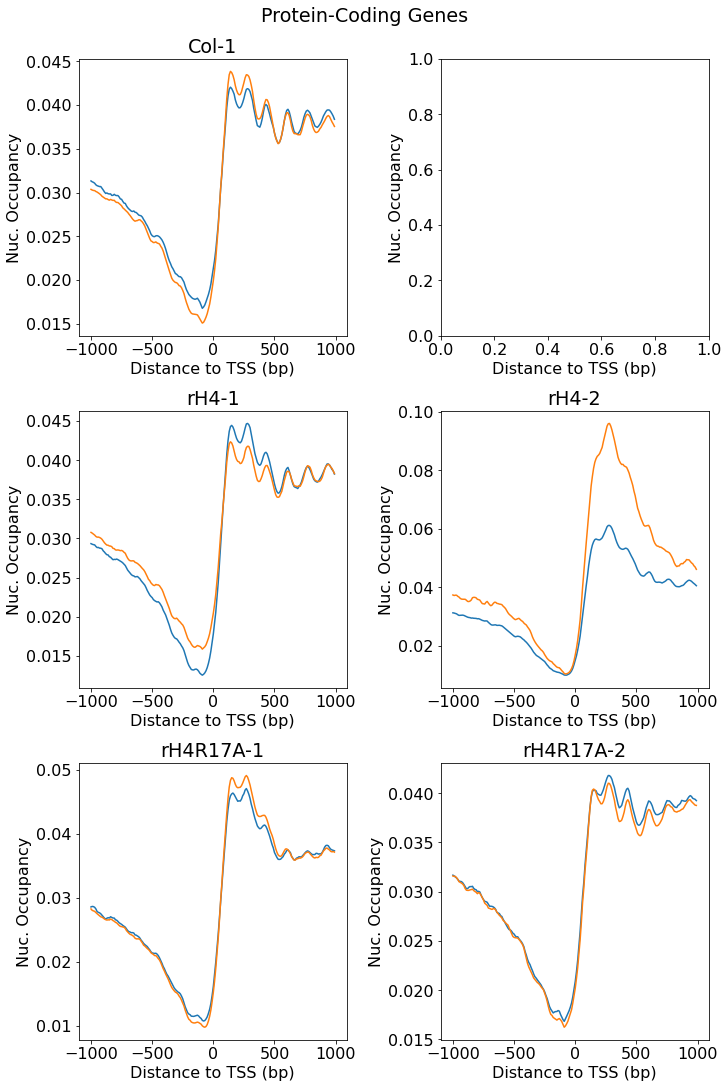

In [19]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#sum all rows
rowsum = data_matrix.sum(axis=0)/27443

#Split data by sample
Col_1a_data = rowsum[0:200].tolist()
Col_1b_data = rowsum[200:400].tolist()
H4WT_1a_data = rowsum[400:600].tolist()
H4WT_1b_data = rowsum[600:800].tolist()
H4WT_2a_data = rowsum[800:1000].tolist()
H4WT_2b_data = rowsum[1000:1200].tolist()
R17A_1a_data = rowsum[1200:1400].tolist()
R17A_1b_data = rowsum[1400:1600].tolist()
R17A_2a_data = rowsum[1600:1800].tolist()
R17A_2b_data = rowsum[1800:2000].tolist()

#Plot data
plt.rcParams.update({'font.size': 16})
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(3, 2, constrained_layout=True)
fig.set_size_inches(10, 15)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col_1a_data)
axs[0, 0].plot(x_vals, Col_1b_data)
axs[0, 0].set_title('Col-1')

axs[1, 0].plot(x_vals, H4WT_1a_data)
axs[1, 0].plot(x_vals, H4WT_1b_data)
axs[1, 0].set_title('rH4-1')

axs[1, 1].plot(x_vals, H4WT_2a_data)
axs[1, 1].plot(x_vals, H4WT_2b_data)
axs[1, 1].set_title('rH4-2')

axs[2, 0].plot(x_vals, R17A_1a_data)
axs[2, 0].plot(x_vals, R17A_1b_data)
axs[2, 0].set_title('rH4R17A-1')

axs[2, 1].plot(x_vals, R17A_2a_data)
axs[2, 1].plot(x_vals, R17A_2b_data)
axs[2, 1].set_title('rH4R17A-2')

fig.suptitle('Protein-Coding Genes')
plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/protein-coding_profiles/reps_together")

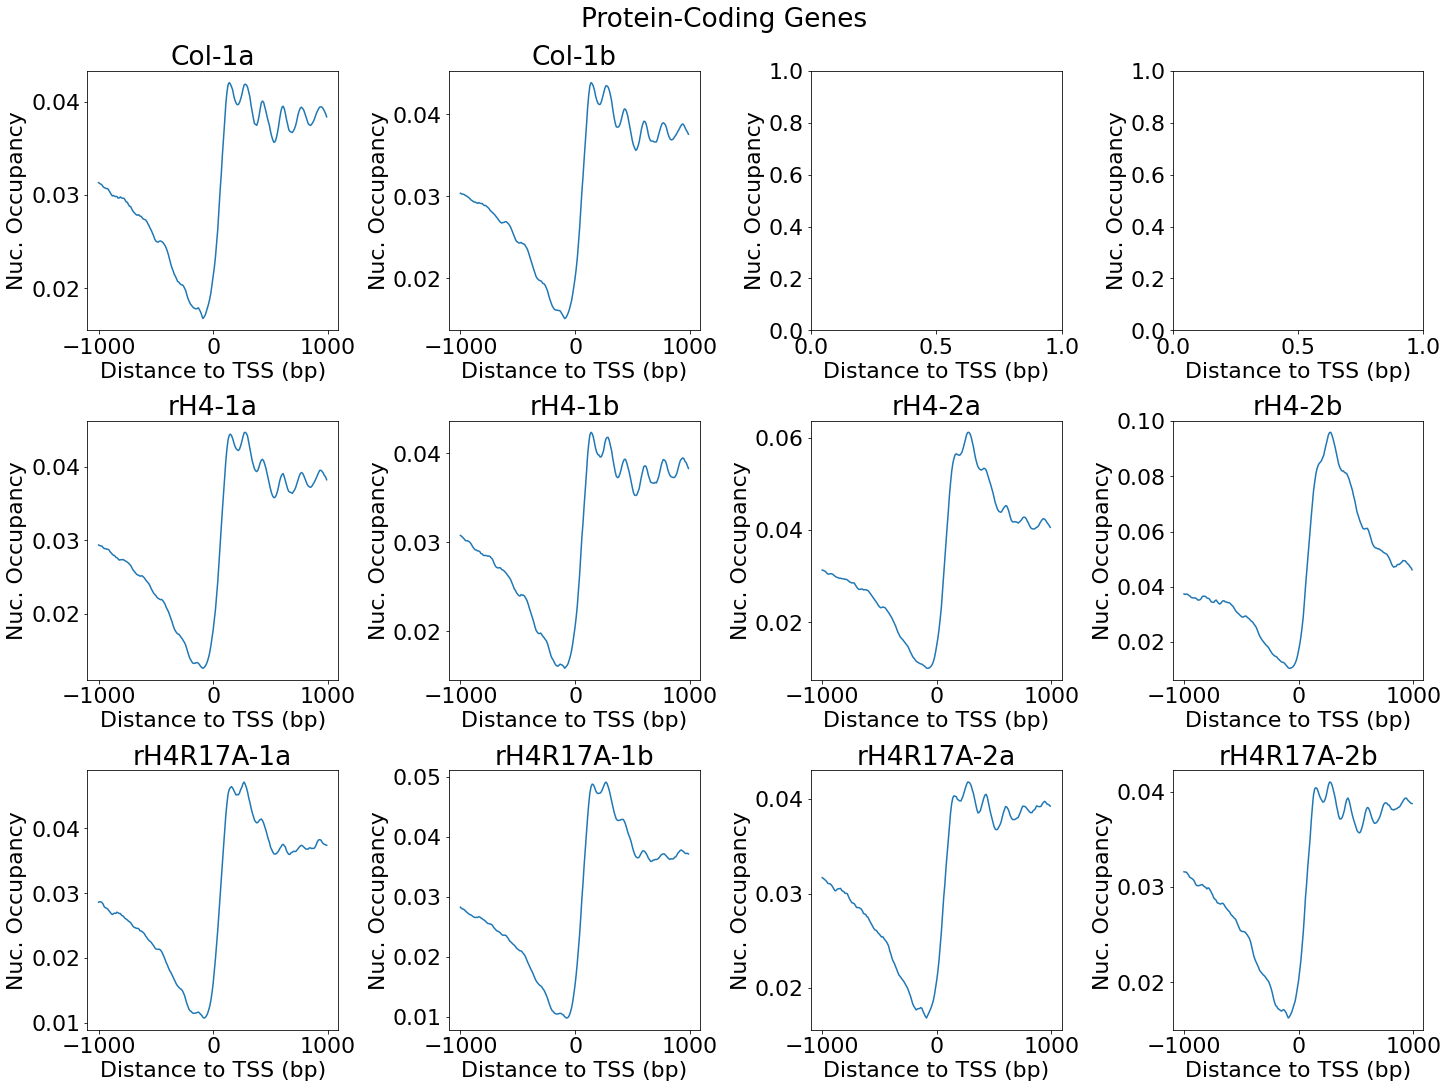

In [20]:
#Plot data
plt.rcParams.update({'font.size': 22})
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(3, 4, constrained_layout=True)
fig.set_size_inches(20, 15)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col_1a_data)
axs[0, 0].set_title('Col-1a')
axs[0, 1].plot(x_vals, Col_1b_data)
axs[0, 1].set_title('Col-1b')

axs[1, 0].plot(x_vals, H4WT_1a_data)
axs[1, 0].set_title('rH4-1a')
axs[1, 1].plot(x_vals, H4WT_1b_data)
axs[1, 1].set_title('rH4-1b')

axs[1, 2].plot(x_vals, H4WT_2a_data)
axs[1, 2].set_title('rH4-2a')
axs[1, 3].plot(x_vals, H4WT_2b_data)
axs[1, 3].set_title('rH4-2b')

axs[2, 0].plot(x_vals, R17A_1a_data)
axs[2, 0].set_title('rH4R17A-1a')
axs[2, 1].plot(x_vals, R17A_1b_data)
axs[2, 1].set_title('rH4R17A-1b')

axs[2, 2].plot(x_vals, R17A_2a_data)
axs[2, 2].set_title('rH4R17A-2a')
axs[2, 3].plot(x_vals, R17A_2b_data)
axs[2, 3].set_title('rH4R17A-2b')

fig.suptitle('Protein-Coding Genes')
plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/protein-coding_profiles/reps_separate")

In [21]:
#Access profile corresponding to a single gene
data_matrix.loc[metadata['gene name'] == 'AT1G01010']

MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm  \
0                                           0.0   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.1  \
0                                          0.0139   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.2  \
0                                         0.02085   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.3  \
0                                         0.06133   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.4  \
0                                          0.0736   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.5  \
0                                         0.06583   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.6  \
0                                         0.06092   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.7  \
0                                         0.02044   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.8  \
0                                        0.008178   

   MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.9  ...  \
0                                        0.002044  ...   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.190  \
0                                             0.1568   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.191  \
0                                             0.1372   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.192  \
0                                            0.08922   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.193  \
0                                            0.01668   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.194  \
0                                            0.02918   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.195  \
0                                            0.03335   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.196  \
0                                            0.03335   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.197  \
0                                            0.02502   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.198  \
0                                            0.03085   

   MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199  
0                                            0.05795  

[1 rows x 2000 columns]

## Combine nucleosome positioning data with expression data from RNA-seq

In [22]:
# Subset data to only include protein coding genes (Chr1-5)
# Load protein coding gene annotation file
base_path = "/Users/emmacorcoran/Desktop/annotations"
filename = "proteincoding_1to5.txt"
path_to_file = os.path.join(base_path, filename)
proteincoding_list = pd.read_csv(path_to_file, sep='\t', header=None)
proteincoding_list.columns = ['gene name','classification']

In [23]:
# Merge metadata with protein coding list
metadata = pd.merge(metadata, proteincoding_list, on="gene name")
metadata

MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm  \
0                                          0.000000   
1                                          0.000000   
2                                          0.002044   
3                                          0.016360   
4                                          0.035570   
...                                             ...   
27438                                      0.017170   
27439                                      0.000000   
27440                                      0.008178   
27441                                      0.029440   
27442                                      0.063380   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.1  \
0                                            0.013900   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.049070   
...                                               ...   
27438                                        0.029030   
27439                                        0.000000   
27440                                        0.018810   
27441                                        0.024940   
27442                                        0.044570   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.2  \
0                                            0.020850   
1                                            0.000000   
2                                            0.008178   
3                                            0.016360   
4                                            0.051110   
...                                               ...   
27438                                        0.040890   
27439                                        0.000000   
27440                                        0.028620   
27441                                        0.040480   
27442                                        0.045800   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.3  \
0                                            0.061330   
1                                            0.000000   
2                                            0.008178   
3                                            0.012270   
4                                            0.076870   
...                                               ...   
27438                                        0.048250   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.048660   
27442                                        0.044160   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.4  \
0                                            0.073600   
1                                            0.000000   
2                                            0.006133   
3                                            0.000000   
4                                            0.075640   
...                                               ...   
27438                                        0.067060   
27439                                        0.000000   
27440                                        0.024530   
27441                                        0.077690   
27442                                        0.050290   

       MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.5  \
0                                            0.065830   
1                                            0.000000   
2                                            0.000000   
3                                            0.006951   
4                                            0.071960   
...                                               ...   
27438                                        0.060920   
27439                                        0.008587   
27440                                        0.013900   
27441                               

In [24]:
#Load RNA-seq tpm expression data
def rnaseq_load(path):
    tpm_file = pd.read_csv(path, sep='\t', header=0)
    tpm_file.columns = ['gene name','rep1','rep2']
    tpm_file['avg'] = tpm_file[['rep1', 'rep2']].mean(axis=1)
    tpm_file = tpm_file.sort_values(by=['gene name'])
    return tpm_file

In [25]:
base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/ordered_tpm_avg/"

#Load Col expression data
filename = "Col_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
Col_tpm = rnaseq_load(path_to_file)

#Load H4WT expression data
filename = "H4WT_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
H4WT_tpm = rnaseq_load(path_to_file)

#Load H4R17A expression data
filename = "R17A_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
R17A_tpm = rnaseq_load(path_to_file)

In [26]:
#Merge metadata with tpm expression data and subset for one sample, plot expression groups
def rowsum_tpm(all_data, tpm_label):
    tpm_data = all_data.loc[all_data['expression category'] == tpm_label]
    tpm_data = tpm_data.iloc[:,0:200]
    nrow = tpm_data.shape[0]
    tpm_rowsum = np.array(tpm_data.sum(axis=0))/nrow
    return tpm_rowsum

In [27]:
def tpm_expression_4groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=2.5)
    print('Very high expression: ' + str(np.count_nonzero(high_tpm)))
    medhigh_tpm = ((subset_data['expression']>=0.5) & (subset_data['expression']<2.5))
    print('High expression: ' + str(np.count_nonzero(medhigh_tpm)))
    medlow_tpm = ((subset_data['expression']>0) & (subset_data['expression']<0.5))
    print('Low expression: ' + str(np.count_nonzero(medlow_tpm)))
    low_tpm = (subset_data['expression']==0)
    print('Very low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "very high"
    subset_data.loc[medhigh_tpm==True, ['expression category']] = "high"
    subset_data.loc[medlow_tpm==True, ['expression category']] = "low"
    subset_data.loc[low_tpm==True, ['expression category']] = "very low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "very high")
    medhigh_rowsum = rowsum_tpm(subset_data, "high")
    medlow_rowsum = rowsum_tpm(subset_data, "low")
    low_rowsum = rowsum_tpm(subset_data, "very low")
    
    #Produce nucleosome occupancy plots of tpm expression groups
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(15, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[3].plot(x_vals, high_rowsum)
    axs[3].set_title('Very High')
    axs[2].plot(x_vals, medhigh_rowsum)
    axs[2].set_title("High")
    axs[1].plot(x_vals, medlow_rowsum)
    axs[1].set_title("Low")
    axs[0].plot(x_vals, low_rowsum)
    axs[0].set_title("Very Low")
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tpm_profiles_4groups/reps_together"+name)
    
    return subset_data

In [28]:
def tpm_expression_2groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=0.02)
    print('High expression: ' + str(np.count_nonzero(high_tpm)))
    low_tpm = (subset_data['expression']<0.02)
    print('Low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "high"
    subset_data.loc[low_tpm==True, ['expression category']] = "low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "high")
    low_rowsum = rowsum_tpm(subset_data, "low")
    
    #Produce nucleosome occupancy plots of tpm expression groups
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[1].plot(x_vals, high_rowsum)
    axs[1].set_title("High")
    axs[0].plot(x_vals, low_rowsum)
    axs[0].set_title("Low")
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tpm_profiles_2groups/reps_together"+name)
    
    return subset_data

Very high expression: 9303
High expression: 6314
Low expression: 5881
Very low expression: 5945
Very high expression: 9303
High expression: 6314
Low expression: 5881
Very low expression: 5945
High expression: 20484
Low expression: 6959
High expression: 20484
Low expression: 6959


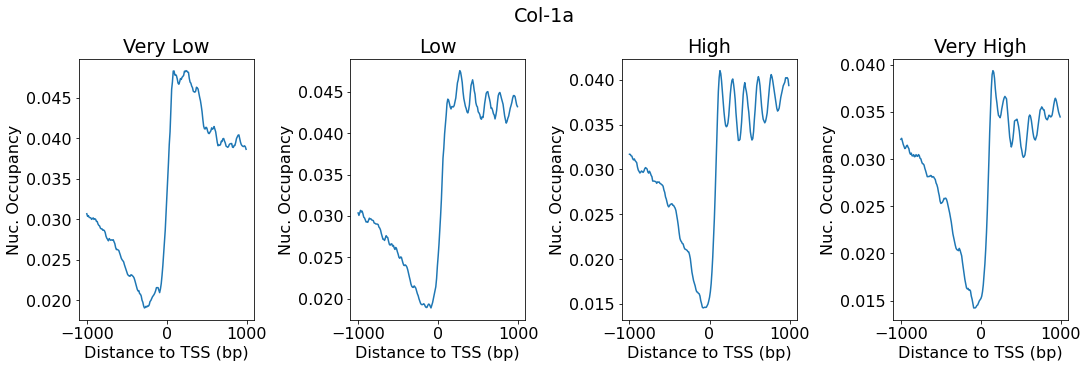

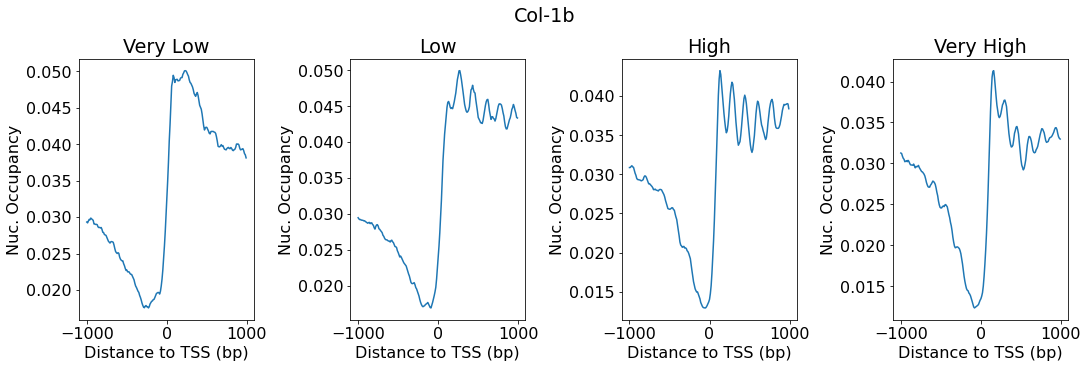

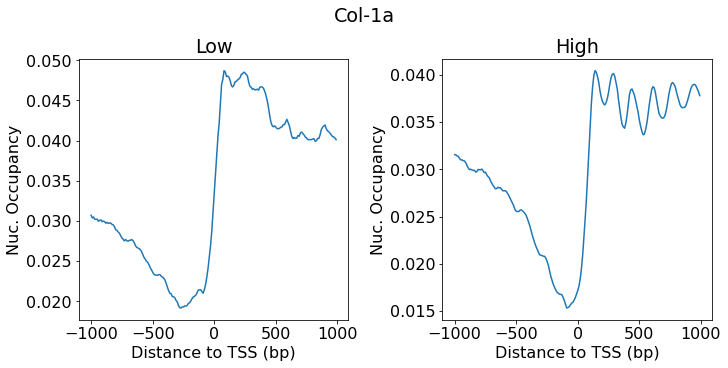

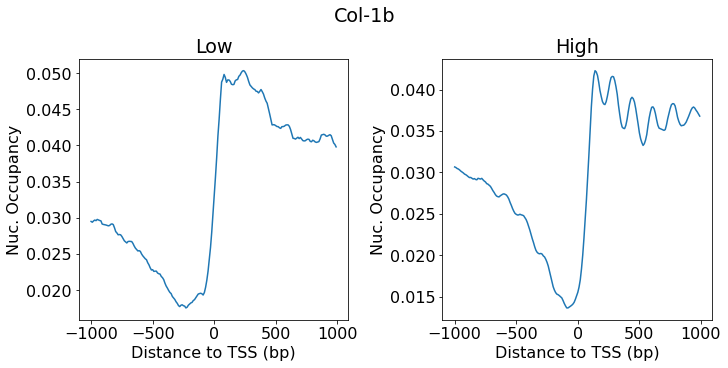

In [29]:
Col1a_4subset = tpm_expression_4groups(metadata, Col_tpm, "MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "Col-1a")
Col1b_4subset = tpm_expression_4groups(metadata, Col_tpm, "MNase-2_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-2_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "Col-1b")
Col1a_2subset = tpm_expression_2groups(metadata, Col_tpm, "MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "Col-1a")
Col1b_2subset = tpm_expression_2groups(metadata, Col_tpm, "MNase-2_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-2_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "Col-1b")

Very high expression: 7031
High expression: 7201
Low expression: 6710
Very low expression: 6501
Very high expression: 7031
High expression: 7201
Low expression: 6710
Very low expression: 6501
High expression: 19852
Low expression: 7591
High expression: 19852
Low expression: 7591


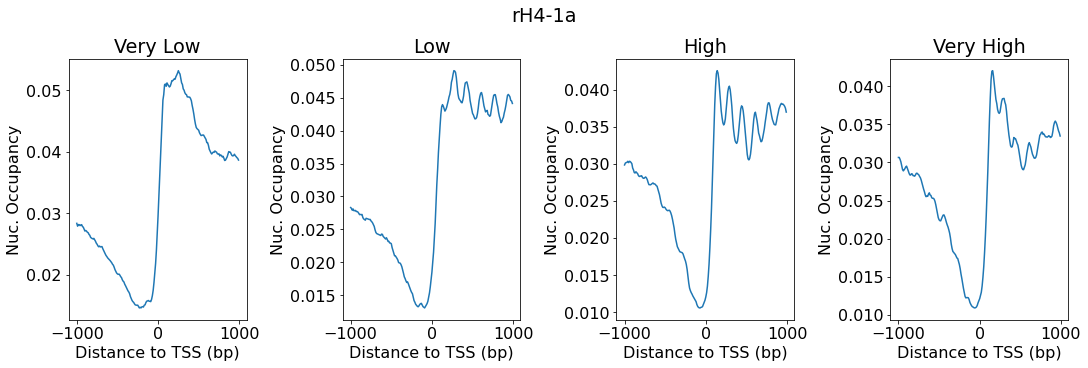

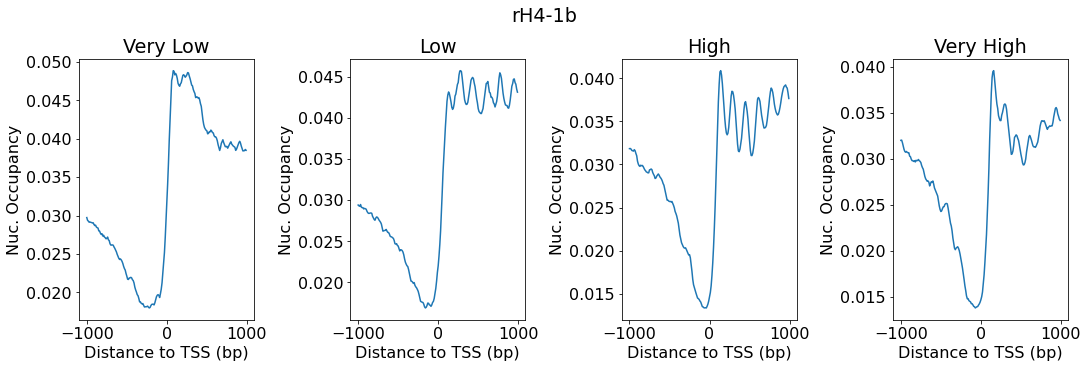

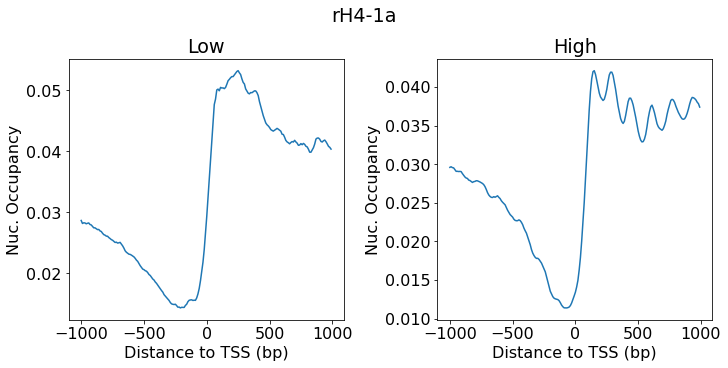

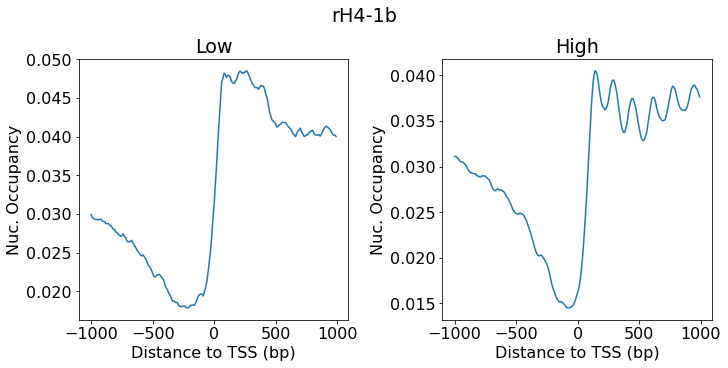

In [30]:
H4WT1a_4subset = tpm_expression_4groups(metadata, H4WT_tpm, "MNase-3_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-3_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-1a")
H4WT1b_4subset = tpm_expression_4groups(metadata, H4WT_tpm, "MNase-4_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-4_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-1b")
H4WT1a_2subset = tpm_expression_2groups(metadata, H4WT_tpm, "MNase-3_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-3_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-1a")
H4WT1b_2subset = tpm_expression_2groups(metadata, H4WT_tpm, "MNase-4_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-4_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-1b")

Very high expression: 7031
High expression: 7201
Low expression: 6710
Very low expression: 6501
Very high expression: 7031
High expression: 7201
Low expression: 6710
Very low expression: 6501
High expression: 19852
Low expression: 7591
High expression: 19852
Low expression: 7591


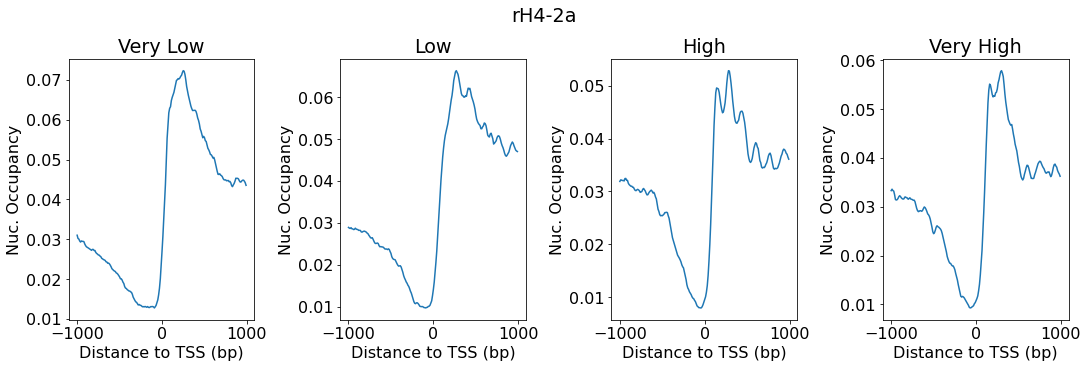

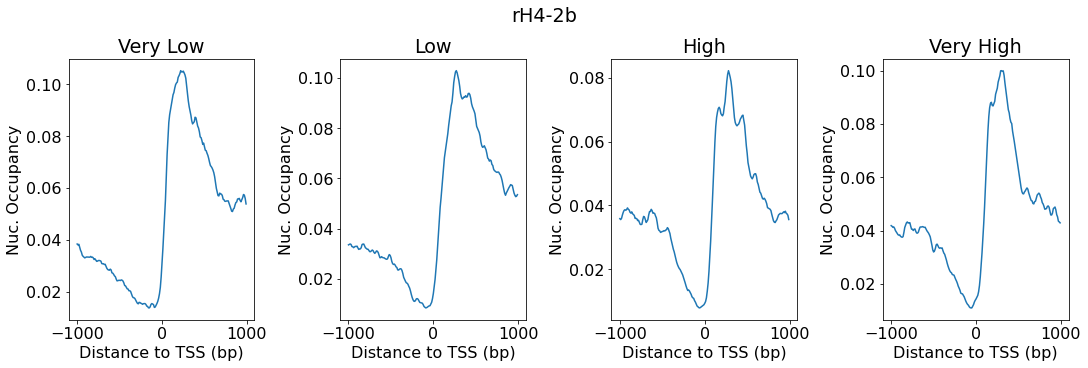

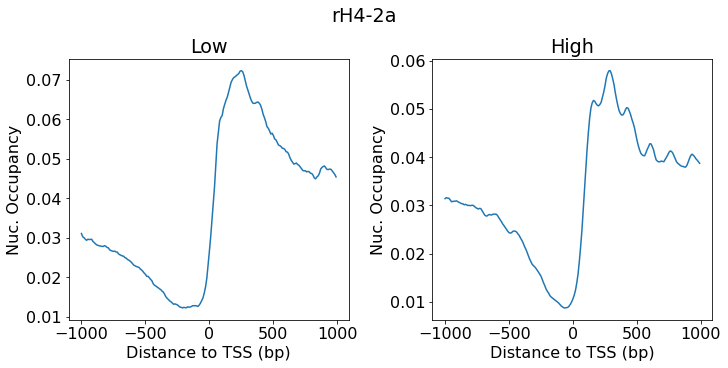

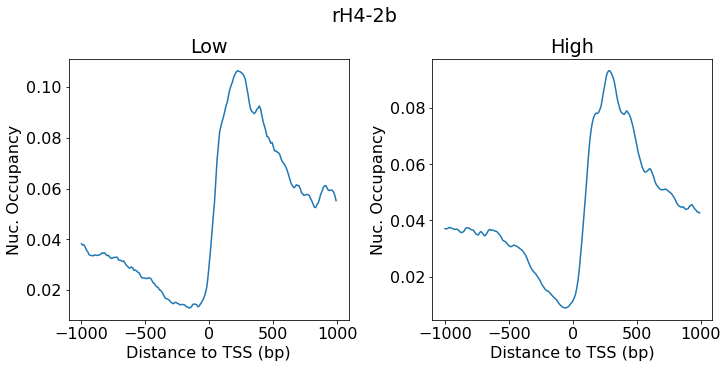

In [31]:
H4WT2a_4subset = tpm_expression_4groups(metadata, H4WT_tpm, "MNase-5_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-5_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-2a")
H4WT2b_4subset = tpm_expression_4groups(metadata, H4WT_tpm, "MNase-6_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-6_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-2b")
H4WT2a_2subset = tpm_expression_2groups(metadata, H4WT_tpm, "MNase-5_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-5_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-2a")
H4WT2b_2subset = tpm_expression_2groups(metadata, H4WT_tpm, "MNase-6_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-6_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4-2b")

Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
High expression: 20257
Low expression: 7186
High expression: 20257
Low expression: 7186


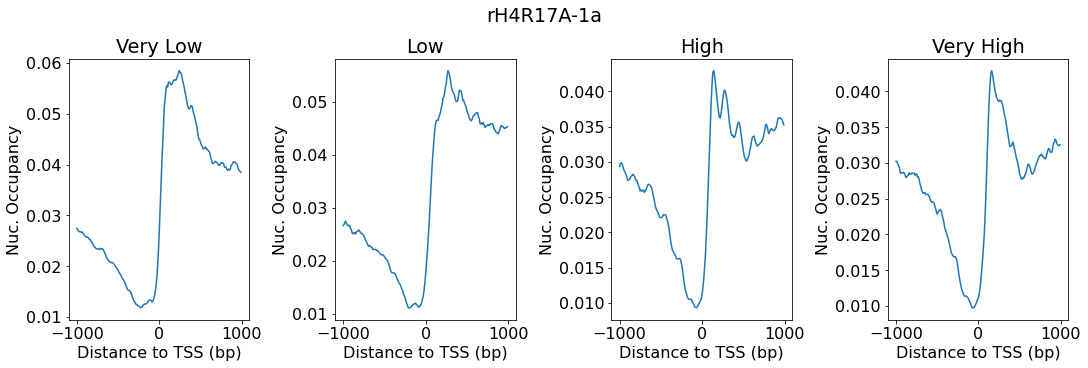

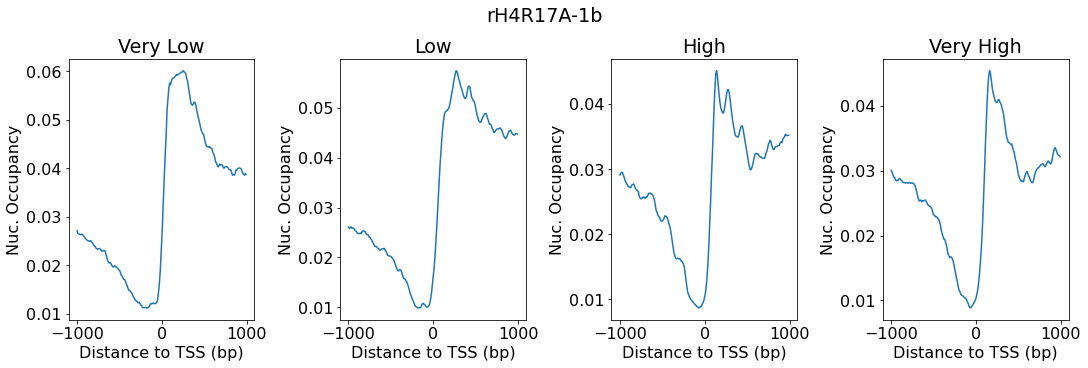

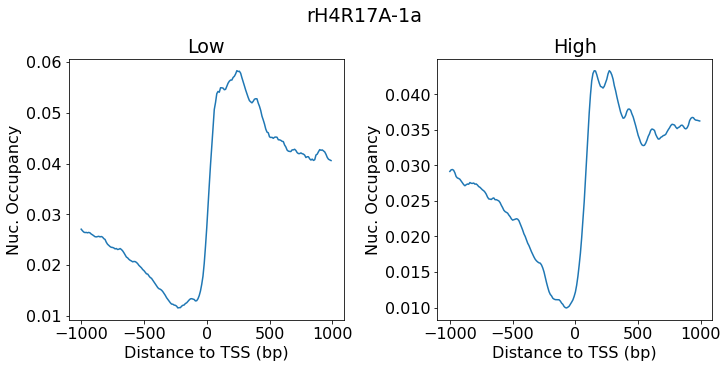

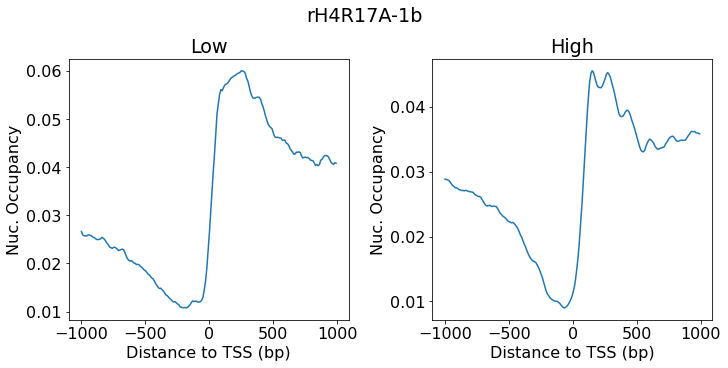

In [32]:
R17A1a_4subset = tpm_expression_4groups(metadata, R17A_tpm, "MNase-7_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-7_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-1a")
R17A1b_4subset = tpm_expression_4groups(metadata, R17A_tpm, "MNase-8_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-8_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-1b")
R17A1a_2subset = tpm_expression_2groups(metadata, R17A_tpm, "MNase-7_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-7_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-1a")
R17A1b_2subset = tpm_expression_2groups(metadata, R17A_tpm, "MNase-8_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-8_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-1b")

Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
High expression: 20257
Low expression: 7186
High expression: 20257
Low expression: 7186


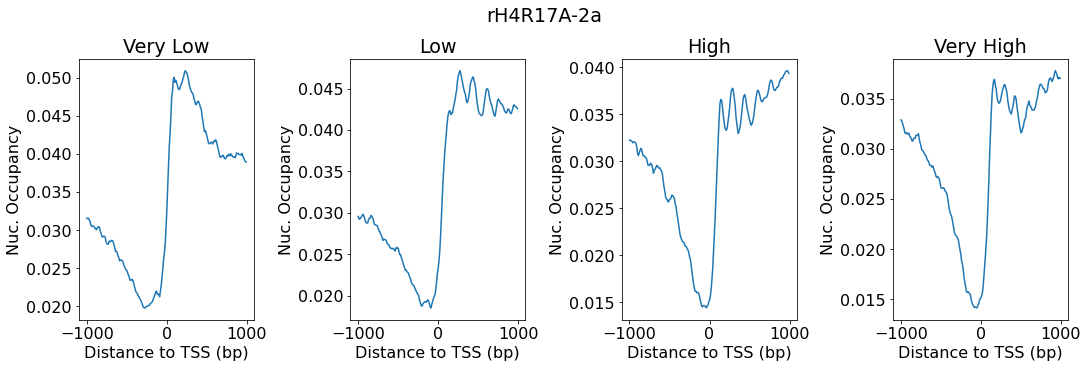

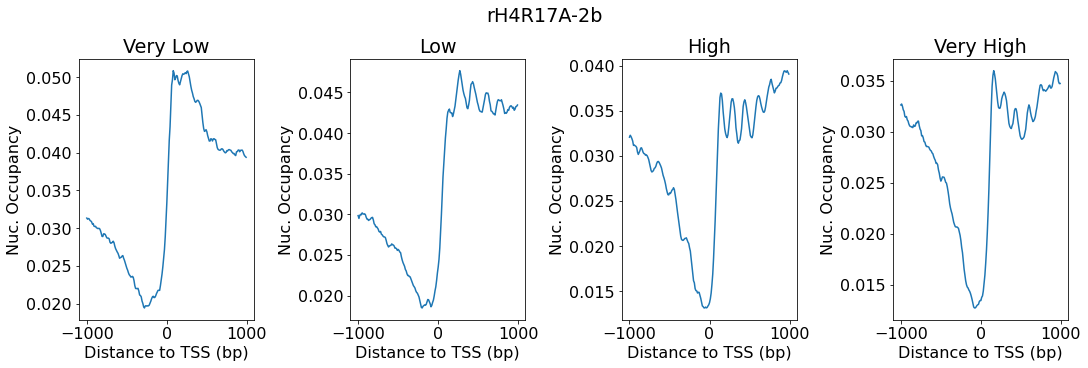

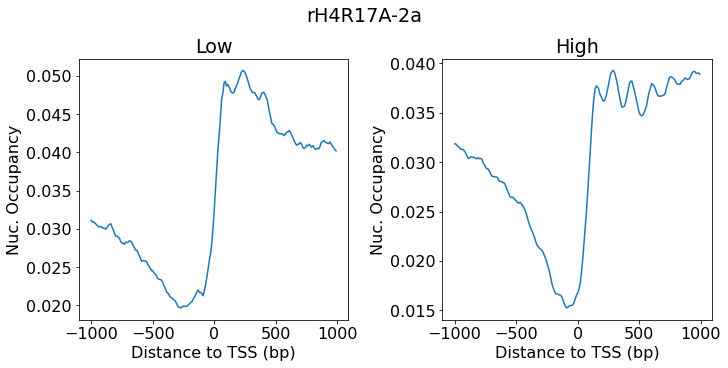

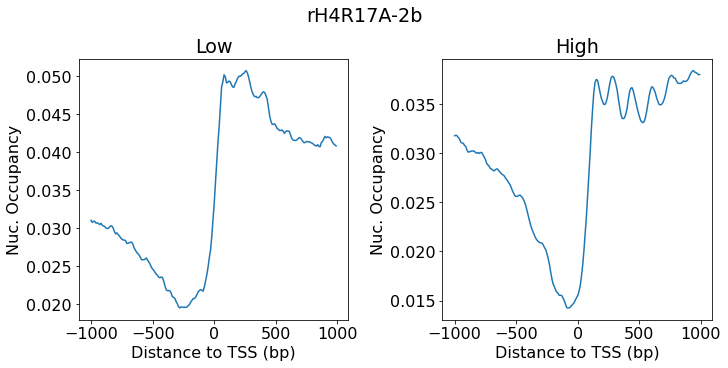

In [33]:
R17A2a_4subset = tpm_expression_4groups(metadata, R17A_tpm, "MNase-9_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-9_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-2a")
R17A2b_4subset = tpm_expression_4groups(metadata, R17A_tpm, "MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-2b")
R17A2a_2subset = tpm_expression_2groups(metadata, R17A_tpm, "MNase-9_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-9_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-2a")
R17A2b_2subset = tpm_expression_2groups(metadata, R17A_tpm, "MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm","MNase-10_AHYWWFDSXY_L001-140-160.mnase-fcnorm.199", "rH4R17A-2b")

In [34]:
# Load DEG data
def deg_load(path, name):
    deg_file = pd.read_csv(path_to_file, sep='\t', header=None)
    deg_file.columns = [name]
    return deg_file

base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/"

#chr11/17 down-regulated genes
filename = "chr_downreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_downreg = deg_load(path_to_file, "gene name")

#chr11/17 up-regulated genes
filename = "chr_upreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_upreg = deg_load(path_to_file, "gene name")

#R17A down-regulated genes
filename = "R17A_downreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_downreg = deg_load(path_to_file, "gene name")

#R17A up-regulated genes
filename = "R17A_upreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_upreg = deg_load(path_to_file, "gene name")

In [35]:
#Merge metadata with DEG data
chr_downreg_subset = pd.merge(metadata, chr_downreg, on="gene name")
chr_upreg_subset = pd.merge(metadata, chr_upreg, on="gene name")
chr_deg_subset = chr_downreg_subset.append(chr_upreg_subset)
R17A_downreg_subset = pd.merge(metadata, R17A_downreg, on="gene name")
R17A_upreg_subset = pd.merge(metadata, R17A_upreg, on="gene name")
R17A_deg_subset = R17A_downreg_subset.append(R17A_upreg_subset)
R17A_deg_subset

MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm  \
0                                        0.000409   
1                                        0.035160   
2                                        0.061740   
3                                        0.047840   
4                                        0.016360   
..                                            ...   
561                                      0.111600   
562                                      0.003680   
563                                      0.000000   
564                                      0.000000   
565                                      0.013900   

     MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.1  \
0                                          0.016360   
1                                          0.053560   
2                                          0.053160   
3                                          0.049070   
4                                          0.016360   
..                                              ...   
561                                        0.092820   
562                                        0.002044   
563                                        0.000000   
564                                        0.000000   
565                                        0.020040   

     MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.2  \
0                                          0.024530   
1                                          0.061330   
2                                          0.085870   
3                                          0.061330   
4                                          0.015950   
..                                              ...   
561                                        0.088730   
562                                        0.008178   
563                                        0.000000   
564                                        0.000000   
565                                        0.024530   

     MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.3  \
0                                          0.024530   
1                                          0.065420   
2                                          0.082600   
3                                          0.043340   
4                                          0.001227   
..                                              ...   
561                                        0.052750   
562                                        0.014720   
563                                        0.000000   
564                                        0.000000   
565                                        0.024530   

     MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.4  \
0                                           0.02412   
1                                           0.11610   
2                                           0.10790   
3                                           0.03353   
4                                           0.00000   
..                                              ...   
561                                         0.02576   
562                                         0.03148   
563                                         0.00000   
564                                         0.00000   
565                                         0.01063   

     MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.5  \
0                                          0.008178   
1                                          0.156600   
2                                          0.111200   
3                                          0.033120   
4                                          0.000000   
..                                              ...   
561                                        0.021670   
562                                        0.036390   
563                                        0.002044   
564                                        0.000000   
565                                        0.008587   

     MNase-1_AHYWWFDSXY_L001-140-160.mnase-fcnorm.6  \
0       

In [36]:
def plot_gene_group(all_data, name):
    #Merge metadata with tpm expression data and subset for one sample
    subset_data = all_data.drop(['gene name', 'classification'],axis=1)
    #Sum rows
    nrow = all_data.shape[0]
    rowsum = np.array(subset_data.sum(axis=0))/nrow

    #Split data by sample
    Col_1a_data = rowsum[0:200].tolist()
    Col_1b_data = rowsum[200:400].tolist()
    H4WT_1a_data = rowsum[400:600].tolist()
    H4WT_1b_data = rowsum[600:800].tolist()
    H4WT_2a_data = rowsum[800:1000].tolist()
    H4WT_2b_data = rowsum[1000:1200].tolist()
    R17A_1a_data = rowsum[1200:1400].tolist()
    R17A_1b_data = rowsum[1400:1600].tolist()
    R17A_2a_data = rowsum[1600:1800].tolist()
    R17A_2b_data = rowsum[1800:2000].tolist()
    
    #Produce nucleosome occupancy plots
    plt.rcParams.update({'font.size': 22})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(3, 4, constrained_layout=True)
    fig.set_size_inches(20, 15)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[0, 0].plot(x_vals, Col_1a_data)
    axs[0, 0].set_title('Col-1a')
    axs[0, 1].plot(x_vals, Col_1b_data)
    axs[0, 1].set_title('Col-1b')

    axs[1, 0].plot(x_vals, H4WT_1a_data)
    axs[1, 0].set_title('rH4-1a')
    axs[1, 1].plot(x_vals, H4WT_1b_data)
    axs[1, 1].set_title('rH4-1b')

    axs[1, 2].plot(x_vals, H4WT_2a_data)
    axs[1, 2].set_title('rH4-2a')
    axs[1, 3].plot(x_vals, H4WT_2b_data)
    axs[1, 3].set_title('rH4-2b')

    axs[2, 0].plot(x_vals, R17A_1a_data)
    axs[2, 0].set_title('rH4R17A-1a')
    axs[2, 1].plot(x_vals, R17A_1b_data)
    axs[2, 1].set_title('rH4R17A-1b')

    axs[2, 2].plot(x_vals, R17A_2a_data)
    axs[2, 2].set_title('rH4R17A-2a')
    axs[2, 3].plot(x_vals, R17A_2b_data)
    axs[2, 3].set_title('rH4R17A-2b')
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/DEG_plots/reps_together_"+name)

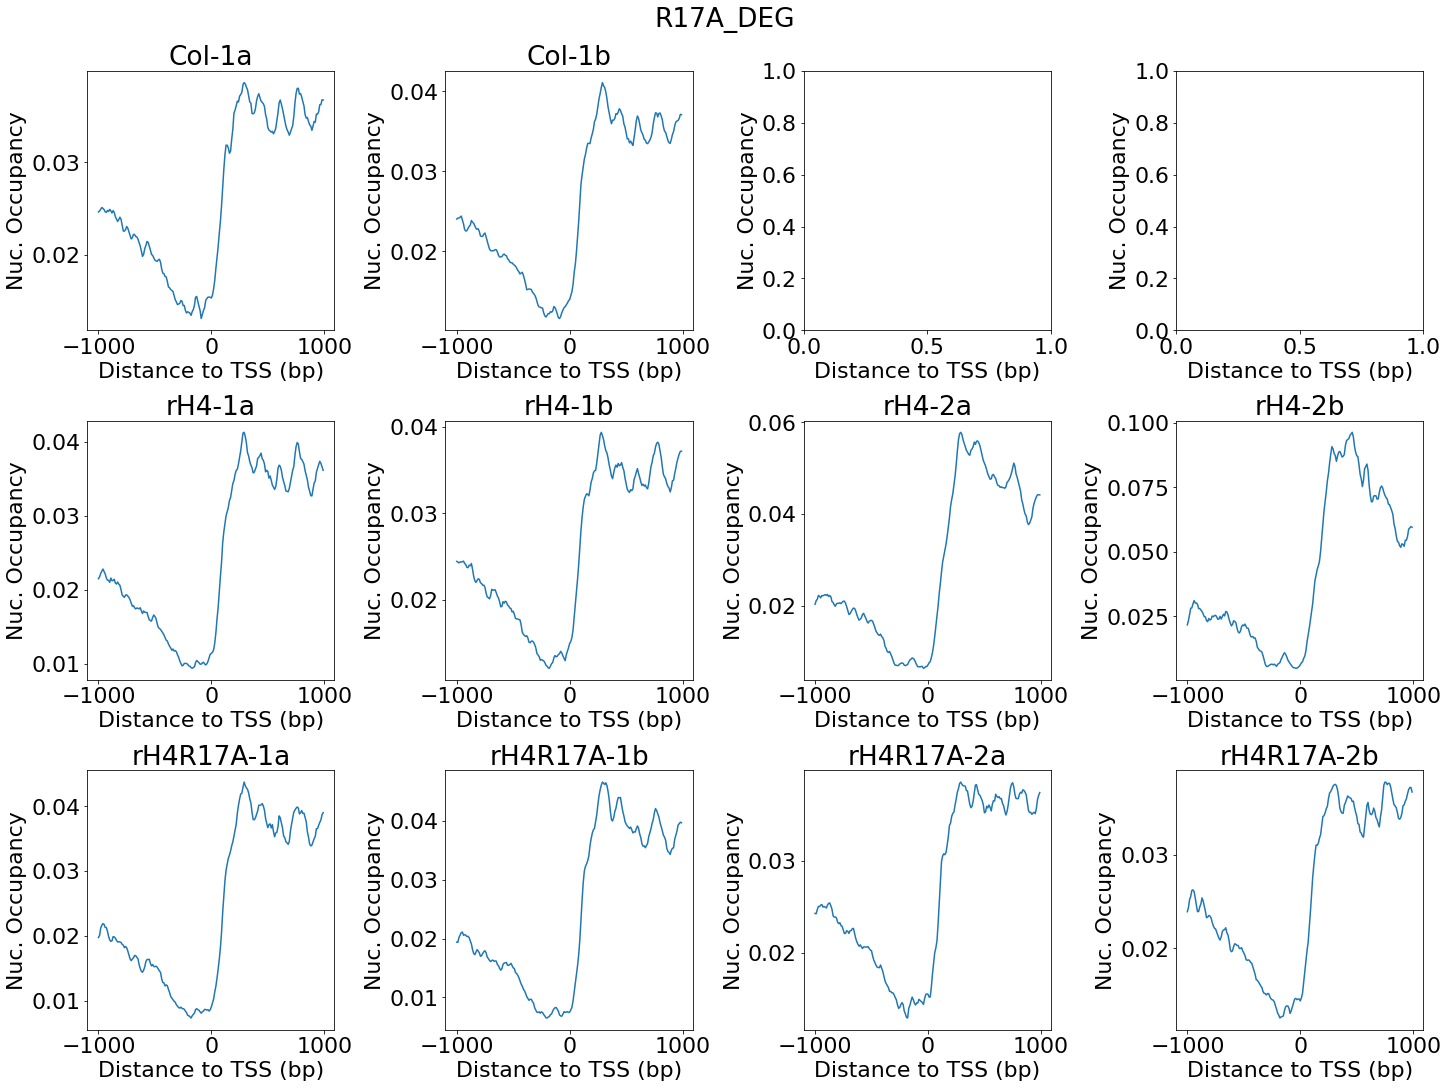

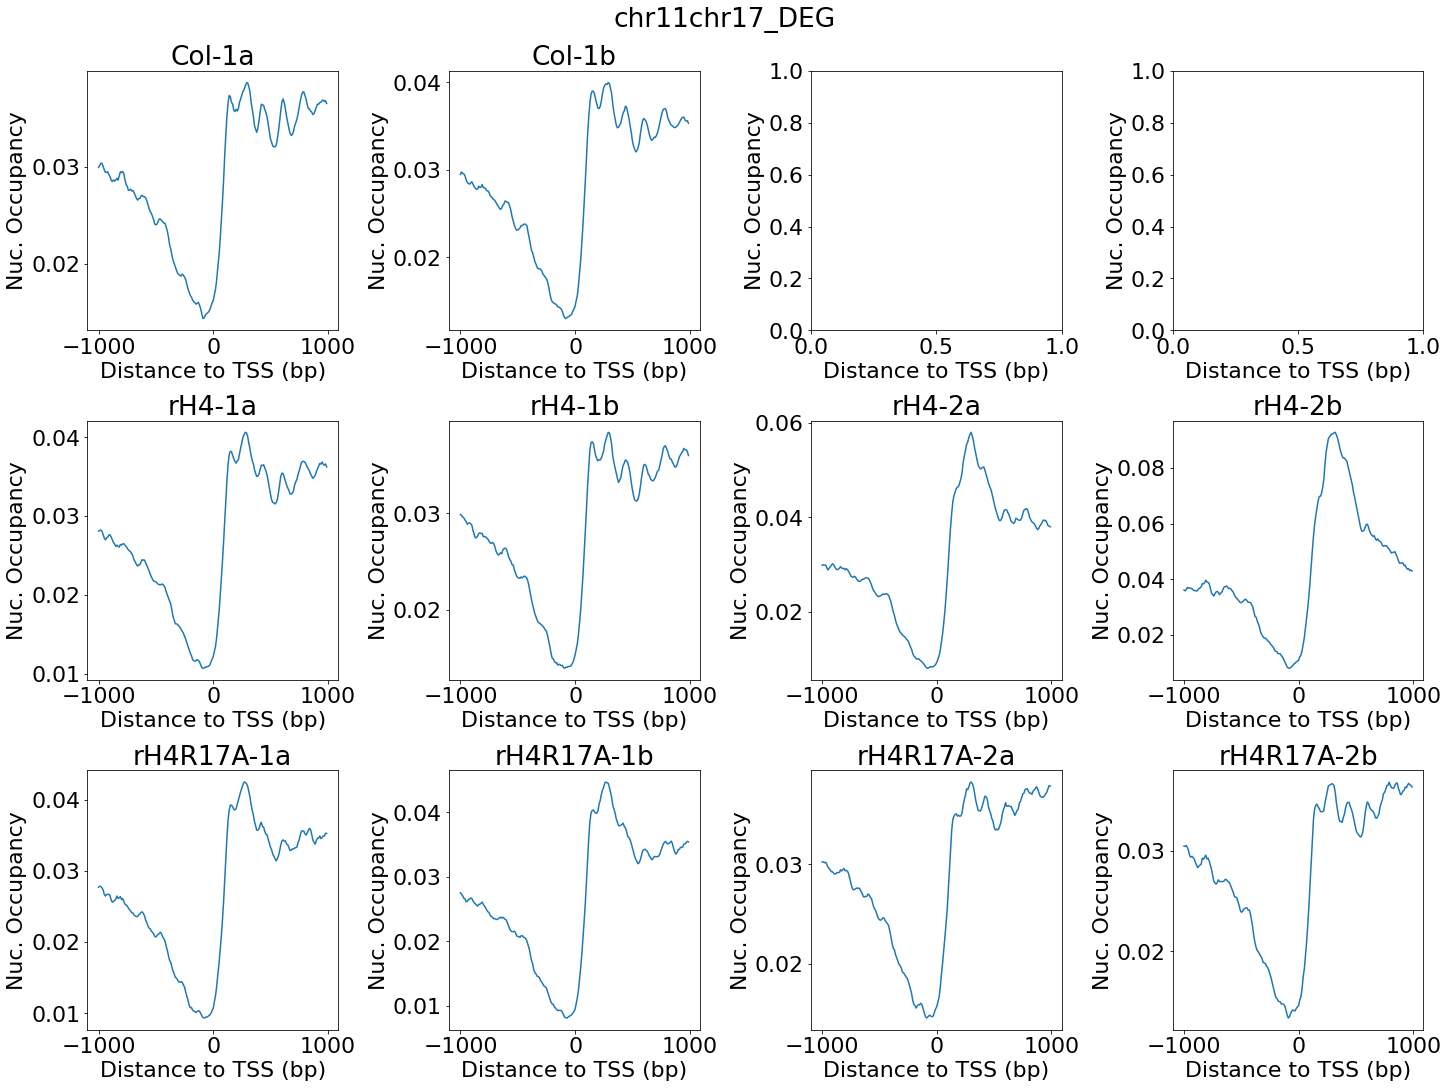

In [37]:
plot_gene_group(R17A_deg_subset, "R17A_DEG")
plot_gene_group(chr_deg_subset, "chr11chr17_DEG")

## Test Different Methods to Reduce Dimensionality and Cluster Data

In [56]:
#Function to get data and targets from data frame
def get_data_targets(df):
    # Separate out the features
    x = df.iloc[:,range(200)].values
    # Separate out the target
    y = df.loc[:,['expression']].values
    y_cat = df.loc[:,['expression category']].values
    # Standardize the features
    x = StandardScaler().fit_transform(x)
    return x,y,y_cat

In [89]:
#Function to section data frame by gene subset
def subset_genes(df, subset_list):
    return pd.merge(subset_list.loc[:,'gene name'], df, on="gene name").drop(['gene name'],axis=1)

In [59]:
#Function to run tSNE
def run_tsne(x):
    # Convert to adjacency matrix
    adjmat = (np.dot(x, x.T) > 0).astype(int)
    # Remove self loop
    np.fill_diagonal(adjmat, 0)
    # Run tSNE
    tsne_embedded = TSNE(n_components=2, perplexity=30).fit_transform(adjmat)
    return tsne_embedded

In [90]:
#Function to perform tSNE on a data frame for each individual sample and plot
def tsne_8samples(df1, df2, df3, df4, df5, df6, df7, df8, name, subsample=True, gene_list=None):
    if subsample==True:
        #Subsample data down to 1000 randomly selected genes to make computations feasible on laptop
        subsample_1, subsample_2, subsample_3, subsample_4, subsample_5, subsample_6, subsample_7, subsample_8 = scprep.select.subsample(df1,df2,df3,df4,df5,df6,df7,df8,n=2000)
    else:
        #Use gene_list to subsection data
        subsample_1 = subset_genes(df1, gene_list)
        subsample_2 = subset_genes(df2, gene_list)
        subsample_3 = subset_genes(df3, gene_list)
        subsample_4 = subset_genes(df4, gene_list)
        subsample_5 = subset_genes(df5, gene_list)
        subsample_6 = subset_genes(df6, gene_list)
        subsample_7 = subset_genes(df7, gene_list)
        subsample_8 = subset_genes(df8, gene_list)
    
    #Get data and targets
    x1, y1, ycat1 = get_data_targets(subsample_1)
    x2, y2, ycat2 = get_data_targets(subsample_2)
    x3, y3, ycat3 = get_data_targets(subsample_3)
    x4, y4, ycat4 = get_data_targets(subsample_4)
    x5, y5, ycat5 = get_data_targets(subsample_5)
    x6, y6, ycat6 = get_data_targets(subsample_6)
    x7, y7, ycat7 = get_data_targets(subsample_7)
    x8, y8, ycat8 = get_data_targets(subsample_8)
    
    # Use tSNE for dimensionality reduction (takes about 10-15 min for 6000 genes)
    tsne_embedded_1 = run_tsne(x1)
    tsne_embedded_2 = run_tsne(x2)
    tsne_embedded_3 = run_tsne(x3)
    tsne_embedded_4 = run_tsne(x4)
    tsne_embedded_5 = run_tsne(x5)
    tsne_embedded_6 = run_tsne(x6)
    tsne_embedded_7 = run_tsne(x7)
    tsne_embedded_8 = run_tsne(x8)
    
    #Plot the data
    # Color by expression category
    fig, axs = plt.subplots(3, 4, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=subsample_1['expression category'].map(colors))
    axs[0, 0].set_title('Col-1a')
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=subsample_2['expression category'].map(colors))
    axs[0, 1].set_title('Col-1b')
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=subsample_3['expression category'].map(colors))
    axs[1, 0].set_title('rH4-1a')
    axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=subsample_4['expression category'].map(colors))
    axs[1, 1].set_title('rH4-1b')
    axs[2, 0].scatter(tsne_embedded_5[:,0], tsne_embedded_5[:,1], s=10, c=subsample_5['expression category'].map(colors))
    axs[2, 0].set_title('rH4R17A-1a')
    axs[2, 1].scatter(tsne_embedded_6[:,0], tsne_embedded_6[:,1], s=10, c=subsample_6['expression category'].map(colors))
    axs[2, 1].set_title('rH4R17A-1b')
    axs[2, 2].scatter(tsne_embedded_7[:,0], tsne_embedded_7[:,1], s=10, c=subsample_7['expression category'].map(colors))
    axs[2, 2].set_title('rH4R17A-2a')
    axs[2, 3].scatter(tsne_embedded_8[:,0], tsne_embedded_8[:,1], s=10, c=subsample_8['expression category'].map(colors))
    axs[2, 3].set_title('rH4R17A-2b')
    
    #Add legend
    classes = ['very high', 'high', 'low', 'very low']
    class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
    recs = []
    for i in range(0,len(class_colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
    plt.legend(recs,classes,loc=4)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tSNE/"+name)

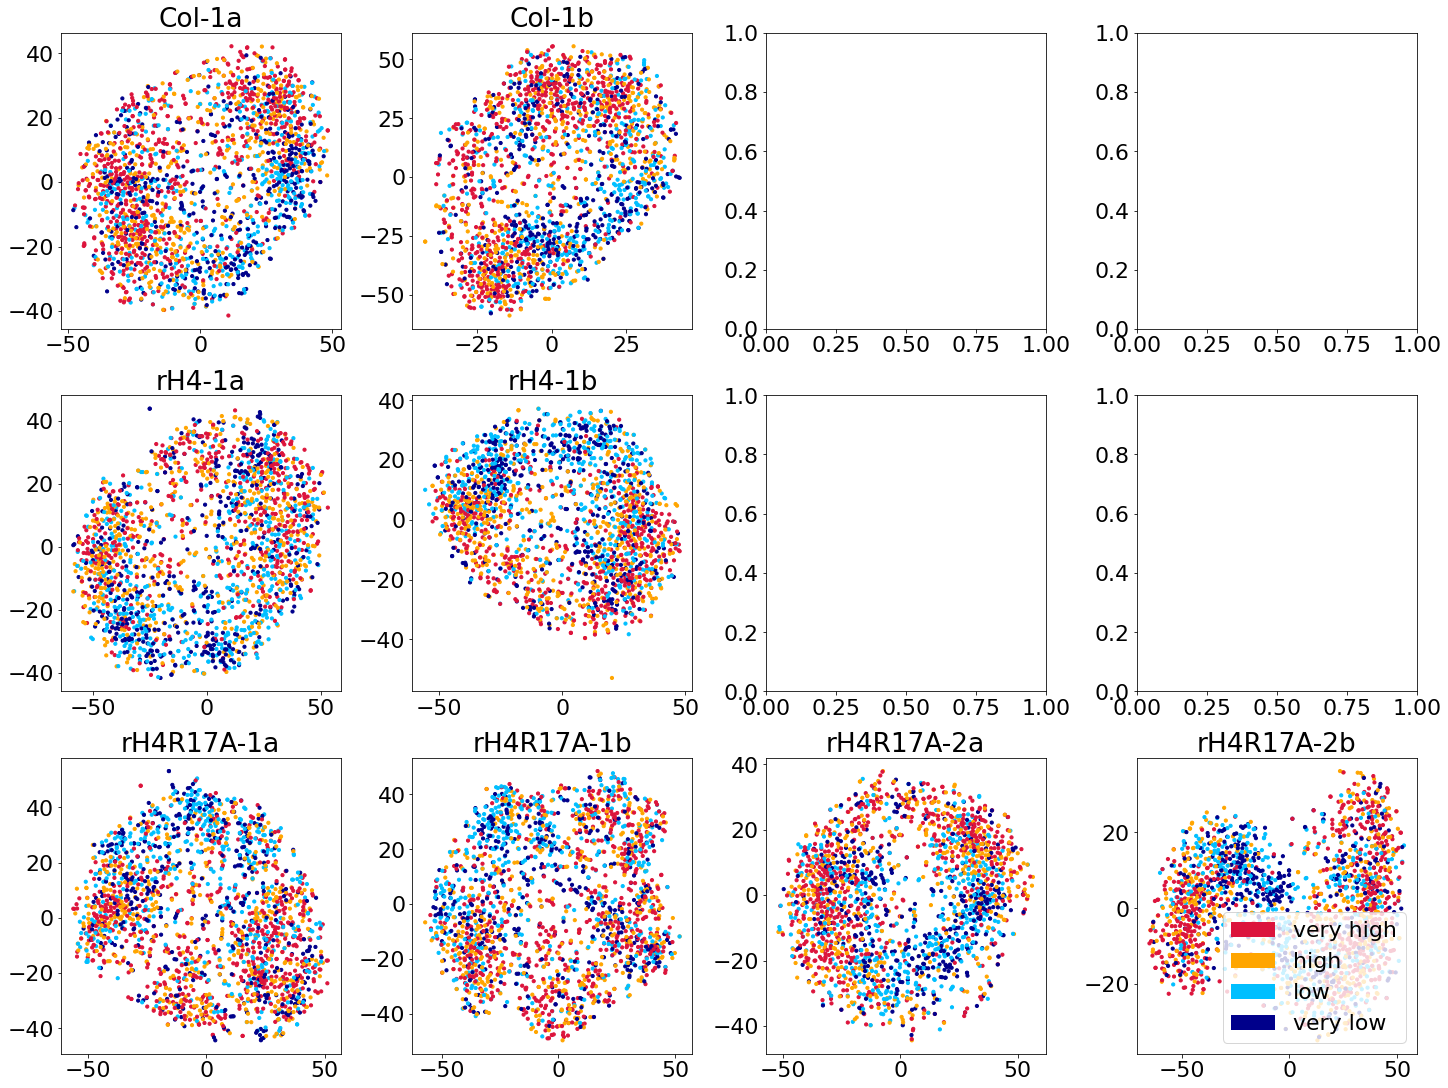

In [69]:
tsne_8samples(Col1a_4subset,Col1b_4subset,H4WT1a_4subset,H4WT1b_4subset,R17A1a_4subset,R17A1b_4subset,R17A2a_4subset,R17A2b_4subset,"rand1_all",subsample=True)

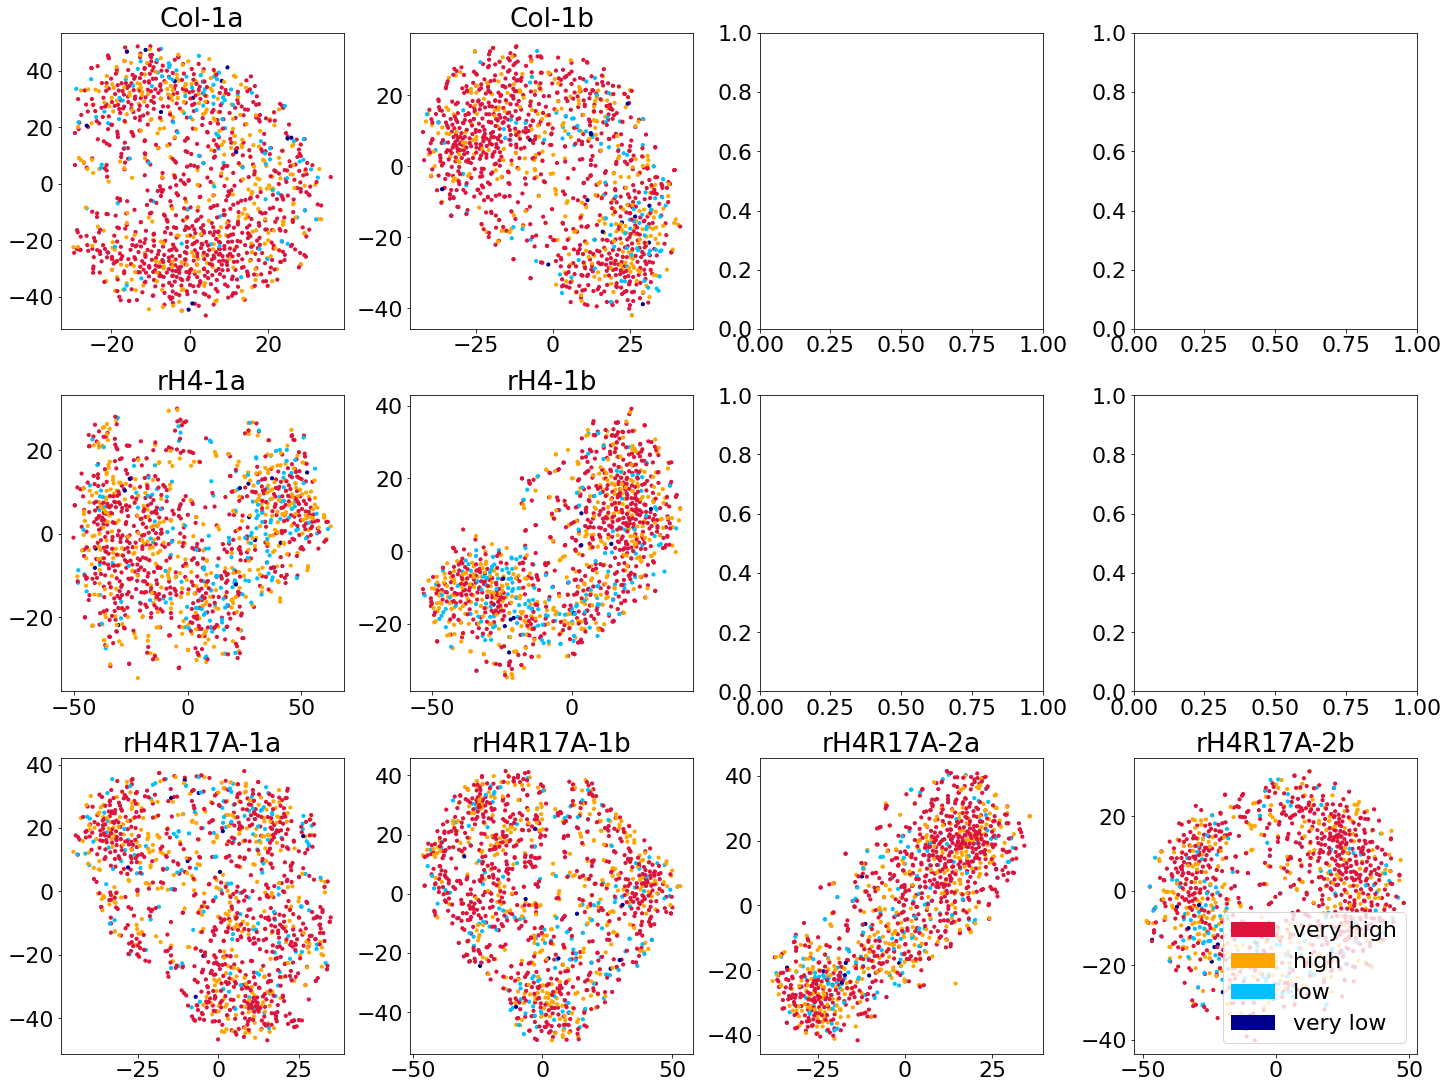

In [91]:
#R17A DEGs
tsne_8samples(Col1a_4subset,Col1b_4subset,H4WT1a_4subset,H4WT1b_4subset,R17A1a_4subset,R17A1b_4subset,R17A2a_4subset,R17A2b_4subset,name="R17A_DEG",subsample=False,gene_list=R17A_deg_subset)

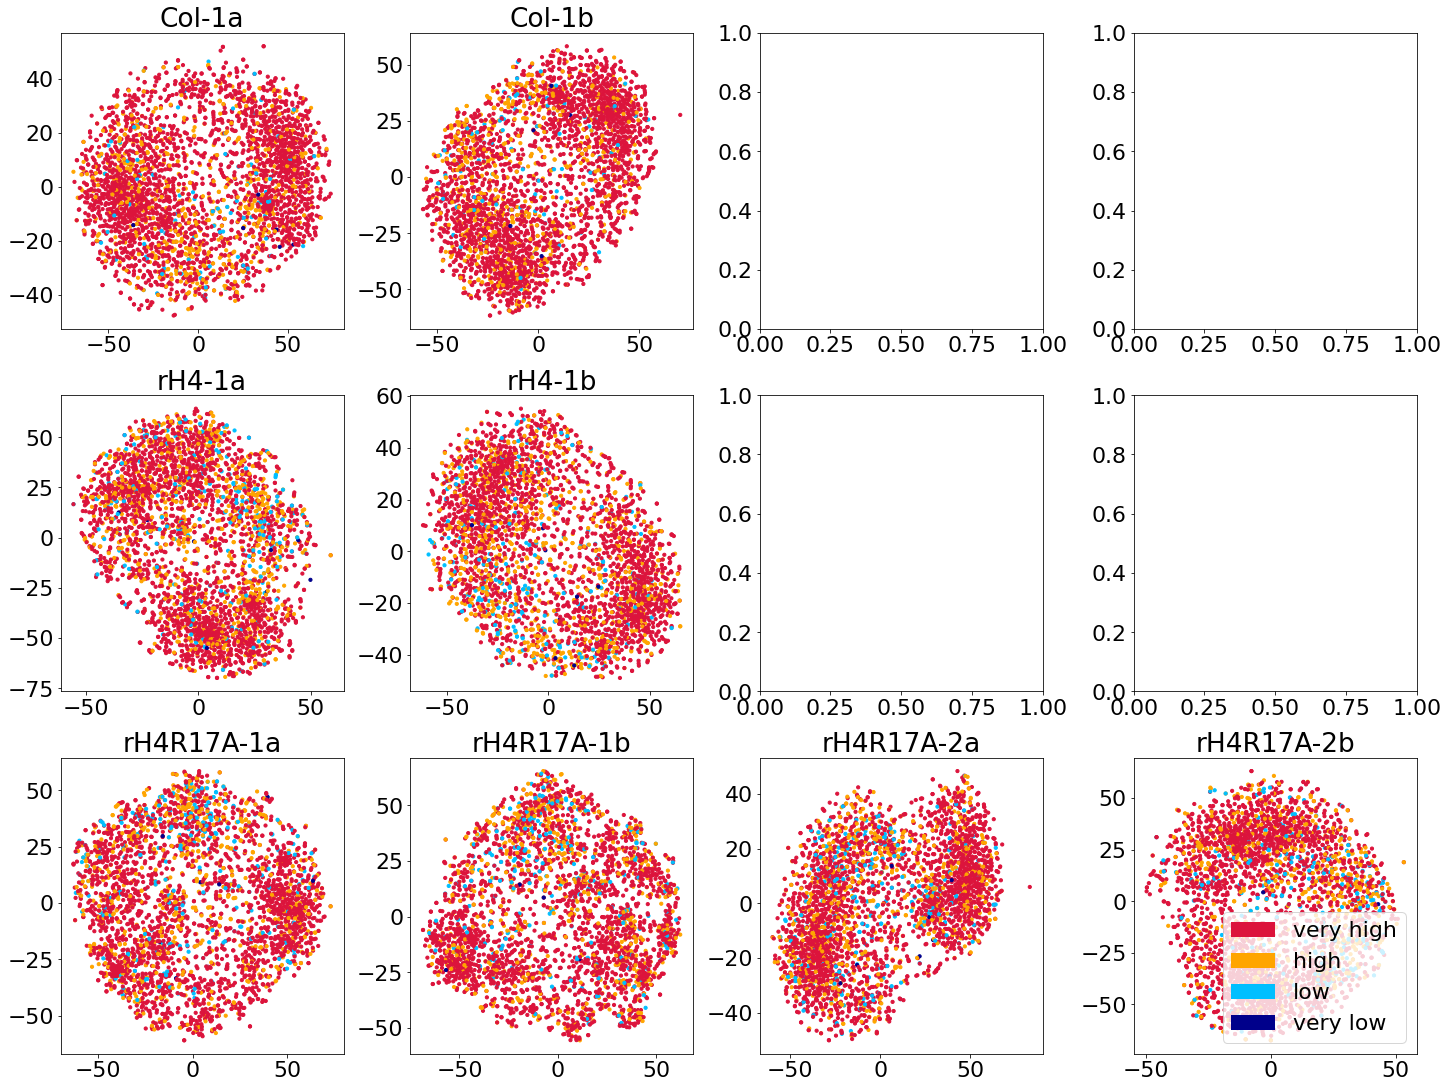

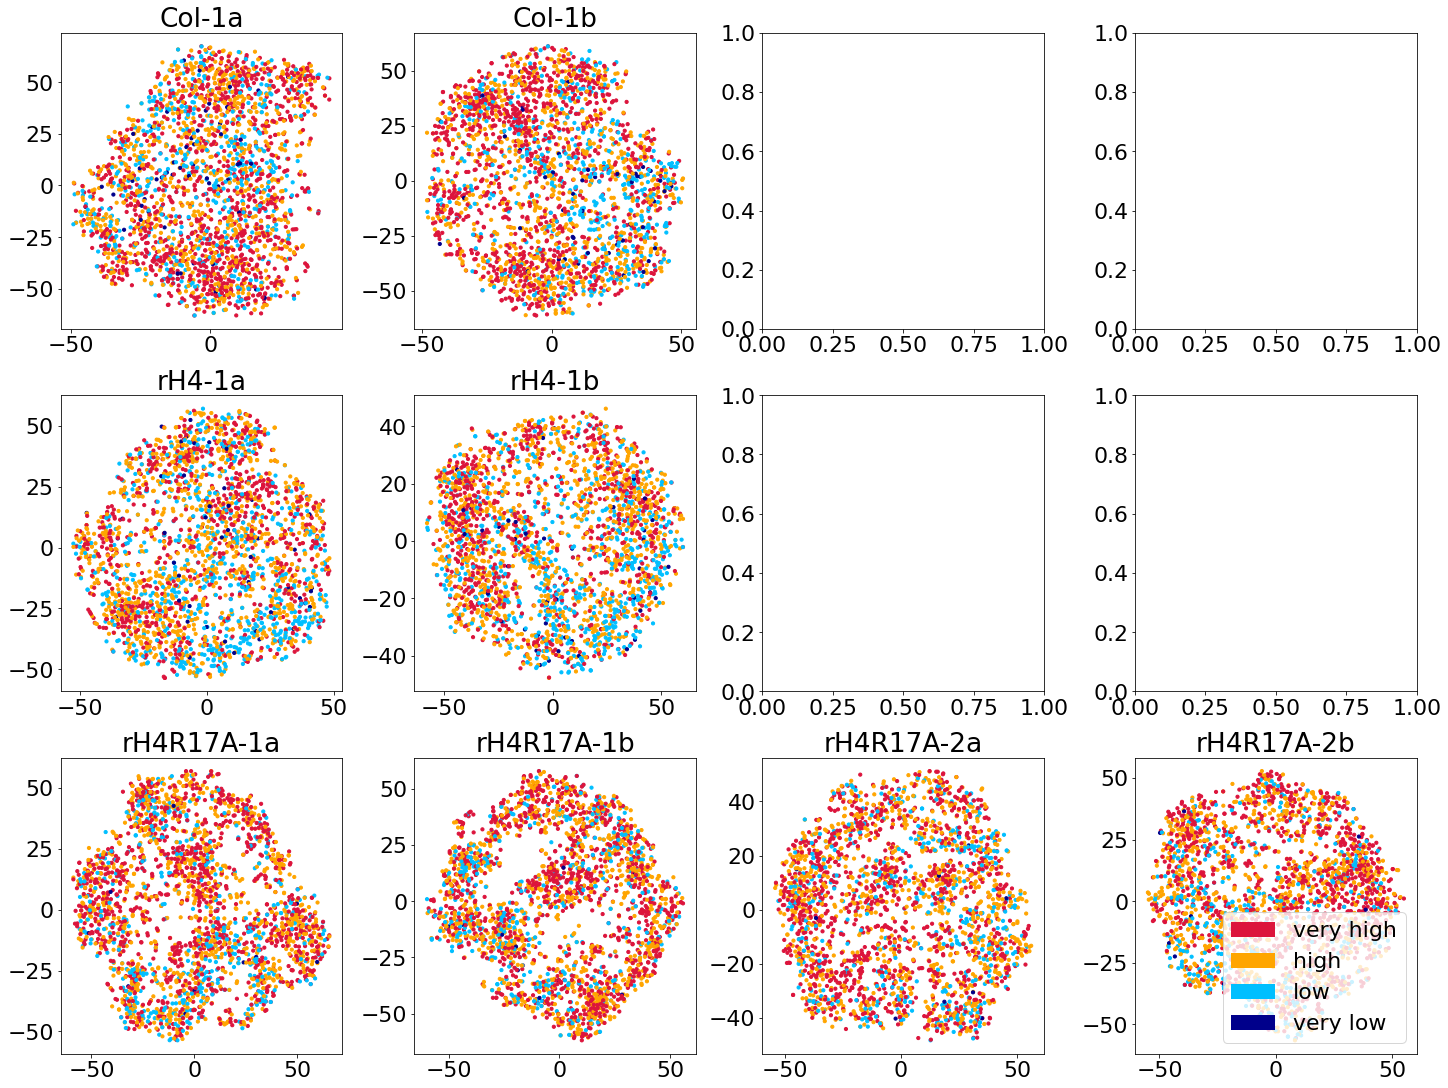

In [92]:
#chr11/17 down-regulated genes
tsne_8samples(Col1a_4subset,Col1b_4subset,H4WT1a_4subset,H4WT1b_4subset,R17A1a_4subset,R17A1b_4subset,R17A2a_4subset,R17A2b_4subset,name="chr_downreg",subsample=False,gene_list=chr_downreg_subset)
#chr11/17 up-regulated genes
tsne_8samples(Col1a_4subset,Col1b_4subset,H4WT1a_4subset,H4WT1b_4subset,R17A1a_4subset,R17A1b_4subset,R17A2a_4subset,R17A2b_4subset,name="chr_upreg",subsample=False,gene_list=chr_upreg_subset)

## Training Feed-Forward Neural Network to Minimize Loss on Assignation of Gene Expression Category (Logistic Regression Classifier)

In [ ]:
# Organize data into correct format and subsample
# Make data frame
df = H4WT_subset_data.copy()
# Separate out the features
x = df.loc[:,'H4WT.mnase-fcnorm':'H4WT.mnase-fcnorm.199'].values
# Separate out the target
y = df.loc[:,['expression']].values
y_cat = df.loc[:,['expression category']].values
## Create categorical labels
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['labels'] = labelencoder.fit_transform(df['expression category'])
labels = df.loc[:,['labels']].values
###Scale values
x = StandardScaler().fit_transform(x)

# Subsample data down to 10000 randomly selected genes
subsample_x, subsample_y, subsample_ycat, labels_subsample = scprep.select.subsample(x, y, y_cat, labels, n=10000)
subsample_data = pd.DataFrame(data = subsample_x)
subsample_data['expression'] = subsample_y
subsample_data['expression category'] = subsample_ycat
subsample_data['labels'] = labels_subsample
# Count number of genes in each expression category to make sure there's an even distribution among expression levels
print('Very high expression: ' + str(np.count_nonzero(subsample_ycat=='very high')))
print('High expression: ' + str(np.count_nonzero(subsample_ycat=='high')))
print('Low expression: ' + str(np.count_nonzero(subsample_ycat=='low')))
print('Very low expression: ' + str(np.count_nonzero(subsample_ycat=='very low')))

In [ ]:
subsample_data

In [ ]:
#Create a training and testing split of the data (80-20 split) and generate minibatches from training data (shuffling the order of the points between epochs)
batch_size = 128

train = subsample_x[:4800,:]
train = torch.tensor(train)
train_labels = labels_subsample[:4800,:]
train_labels = torch.tensor(train_labels)
train_all = torch.utils.data.TensorDataset(train, train_labels)
test = subsample_x[4801:,:]
test = torch.tensor(test)
test_labels = labels_subsample[4801:,:]
test_labels = torch.tensor(test_labels)
test_all = torch.utils.data.TensorDataset(test, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_all, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_all, batch_size=batch_size, shuffle=False)

### Separated genes into 4 categories corresponding to expression level

In [ ]:
#Define Feed Forward Neural Network Class
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    
    def __init__(self): # initialize the model
        super(FeedForwardNet, self).__init__() # call for the parent class to initialize
        hidden_width = 128
        # define the weight and the bias for the input layer
        #initialize with samples from a uniform random distribution in the interval of [-1/sqrt(output_dimension), 1/sqrt(output_dimension)]
        W1_init = (torch.rand(200,hidden_width)-0.5)*(2/np.sqrt(200))
        b1_init = (torch.rand(hidden_width)-0.5)*(2/np.sqrt(200))
        self.W1 = nn.Parameter(W1_init) 
        self.b1 = nn.Parameter(b1_init)
        
        # Create one hidden layer (with 128 units) between the input and output by creating another weight and bias variable.
        W2_init = (torch.rand(hidden_width,4)-0.5)*(2/np.sqrt(hidden_width))
        b2_init = (torch.rand(4)-0.5)*(2/np.sqrt(hidden_width))
        self.W2 = nn.Parameter(W2_init) 
        self.b2 = nn.Parameter(b2_init)

    def forward(self, x):
        """
        function that will be executed when we call the logistic regression on data
        INPUT:
            x, MNase-seq profile represented as tensor of shape 200
        OUTPUT:
            predictions, a tensor of shape 4
        """
        a1 = x@self.W1 + self.b1
        
        #Relu non-linearity before hidden layer
        m = nn.ReLU()
        h1 = m(a1)
        predictions = h1@self.W2 + self.b2
        
        return predictions

In [ ]:
#Define functions to train and evaluate neural network
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 200
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            targets = targets.flatten()
            optimizer.zero_grad()
            
            # run the model on the data
            model_input = data.float()
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out,targets)   #for feed-forward neural network  

            # Find the gradients of our loss via backpropagation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 10 epochs
        if (epoch+1) % 10==0:
            print(f" EPOCH {epoch+1}. Progress: {epoch/num_epochs*100}%. ")
            #print(f" Loss: {loss_fn(out,model_input)}. ") #for autoencoder
            print(f" Train accuracy: {evaluate(model,train_loader)}. Test accuracy: {evaluate(model,test_loader)}") #for feed-forward NN
            
    
def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropagation, which makes the model run much more quickly.
        correct=0
        total=0
        # Iterate through dataset
        for data, targets in evaluation_set:
            targets = targets.flatten()
            model_input = data.float()
            # Forward pass to get the outputs
            out = model(model_input)

            # Get predictions from the maximum value
            _, predicted = torch.max(out.data, 1)

            # Calculate total number of targets
            total = total+targets.size(0)
            
            # Sum total correct predictions
            correct = correct+(predicted == targets).sum()

        accuracy = 100. * correct/total
    return accuracy

In [ ]:
# Initialize model and set parameters
model = FeedForwardNet()
#Create a loss function set to categorical cross-entropy
loss_fn = torch.nn.CrossEntropyLoss()
# initialize a stochastic gradient descent optimizer and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = learning_rate)
#train the model for 100 epochs with a batch size of 128, and a learning rate of 0.5
train(model, loss_fn, SGD, train_loader, test_loader)

#### Conclusion
Approximately 42% accuracy can be achieved with the feed-forward neural network on the optimum settings for the test data set. The training data set reaches 62% accuracy. The neural network is potentially overfitting on the training data, but the neural network still does not achieve a very high accuracy on the training data. The neural network is likely leveling out at this accuracy value because a for a large percentage of the genes, their expression levels cannot be determined by their nucleosome positioning patterns alone. Since genes mainly seem to cluster into two categories (high or low expression), rather than four categories corresponding to expression level, testing the feed-forward neural network on genes separated into two categories may improve its accuracy.

### Separated genes into two categories corresponding to expression level

In [ ]:
### Add column to metadata with 2 gene groups
# Make gene groups and count number of genes in each group
one_tpm = (H4WT_subset_data['expression']>=0.5)
print('High expression: ' + str(np.count_nonzero(one_tpm)))
zero_tpm = (H4WT_subset_data['expression']<0.5)
print('Low expression: ' + str(np.count_nonzero(zero_tpm)))

# Add expression category column to metadata and fill in with values
n = len(H4WT_subset_data['expression'])
H4WT_subset_data['binary expression'] = 0 * n
H4WT_subset_data.loc[one_tpm==True, ['binary expression']] = 1
H4WT_subset_data

In [ ]:
# Organize data into correct format and subsample
# Make data frame
df = H4WT_subset_data.copy()
# Separate out the features
x = df.loc[:,'H4WT.mnase-fcnorm':'H4WT.mnase-fcnorm.199'].values
# Separate out the target
y = df.loc[:,['binary expression']].values
## Create categorical labels
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['labels'] = labelencoder.fit_transform(df['binary expression'])
labels = df.loc[:,['labels']].values
###Scale values
x = StandardScaler().fit_transform(x)

In [ ]:
#Create a training and testing split of the data (80-20 split) and generate minibatches from training data (shuffling the order of the points between epochs)
batch_size = 128

train = x[:22200,:]
train = torch.tensor(train)
train_labels = y[:22200,:]
train_labels = torch.tensor(train_labels)
train_all = torch.utils.data.TensorDataset(train, train_labels)
test = x[22201:,:]
test = torch.tensor(test)
test_labels = y[22201:,:]
test_labels = torch.tensor(test_labels)
test_all = torch.utils.data.TensorDataset(test, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_all, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_all, batch_size=batch_size, shuffle=False)

In [ ]:
#Define Feed Forward Neural Network Class
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    
    def __init__(self): # initialize the model
        super(FeedForwardNet, self).__init__() # call for the parent class to initialize
        hidden_width = 128
        # define the weight and the bias for the input layer
        #initialize with samples from a uniform random distribution in the interval of [-1/sqrt(output_dimension), 1/sqrt(output_dimension)]
        W1_init = (torch.rand(200,hidden_width)-0.5)*(2/np.sqrt(200))
        b1_init = (torch.rand(hidden_width)-0.5)*(2/np.sqrt(200))
        self.W1 = nn.Parameter(W1_init) 
        self.b1 = nn.Parameter(b1_init)
        
        # Create one hidden layer (with 128 units) between the input and output by creating another weight and bias variable.
        W2_init = (torch.rand(hidden_width,2)-0.5)*(2/np.sqrt(hidden_width))
        b2_init = (torch.rand(2)-0.5)*(2/np.sqrt(hidden_width))
        self.W2 = nn.Parameter(W2_init) 
        self.b2 = nn.Parameter(b2_init)

    def forward(self, x):
        """
        function that will be executed when we call the logistic regression on data
        INPUT:
            x, MNase-seq profile represented as tensor of shape 200
        OUTPUT:
            predictions, a tensor of shape 2
        """
        a1 = x@self.W1 + self.b1
        
        #Relu non-linearity before hidden layer
        m = nn.ReLU()
        h1 = m(a1)
        predictions = h1@self.W2 + self.b2
        
        return predictions

In [ ]:
#Define functions to train and evaluate neural network
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 200
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            targets = targets.flatten()
            optimizer.zero_grad()
            
            # run the model on the data
            model_input = data.float()
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out,targets)   #for feed-forward neural network  

            # Find the gradients of our loss via backpropagation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 10 epochs
        if (epoch+1) % 10==0:
            print(f" EPOCH {epoch+1}. Progress: {epoch/num_epochs*100}%. ")
            #print(f" Loss: {loss_fn(out,model_input)}. ") #for autoencoder
            print(f" Train accuracy: {evaluate(model,train_loader)}. Test accuracy: {evaluate(model,test_loader)}") #for feed-forward NN
            
    
def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropagation, which makes the model run much more quickly.
        correct=0
        total=0
        # Iterate through dataset
        for data, targets in evaluation_set:
            targets = targets.flatten()
            model_input = data.float()
            # Forward pass to get the outputs
            out = model(model_input)

            # Get predictions from the maximum value
            _, predicted = torch.max(out.data, 1)

            # Calculate total number of targets
            total = total+targets.size(0)
            
            # Sum total correct predictions
            correct = correct+(predicted == targets).sum()

        accuracy = 100. * correct/total
    return accuracy

In [ ]:
# Initialize model and set parameters
model = FeedForwardNet()
#Create a loss function set to categorical cross-entropy
loss_fn = torch.nn.CrossEntropyLoss()
# initialize a stochastic gradient descent optimizer and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = learning_rate)
#train the model for 100 epochs with a batch size of 128, and a learning rate of 0.5
train(model, loss_fn, SGD, train_loader, test_loader)

#### Conclusion
Approximately 74% accuracy can be achieved with the feed-forward neural network on the optimum settings for the test data set, while the training data set reaches 85% accuracy. This represents a marked improvement (~32%) over the neural network that categorized the genes into four expression categories. While utilizing fewer categories does ensure that the algorithm has a higher chance of assigning the correct classification by pure chance, the improvement seen with the 2-category classification is still significant. These data indicate that nucleosome positioning patterns associated with protein-coding genes largely cluster into two main clusters corresponding to high or low expression, rather than four main clusters corresponding to very high, high, low, and very low expression. However, the neural network is likely unable to correctly classify the remaining ~25% of genes because the expression levels of many genes is likely not determinable by their nucleosome positioning patterns alone. The noisiness of the dimensionality reduced data further supports this conclusion.